In [1]:
import random
import os
import matplotlib.pyplot as plt
import pickle
import itertools
import numpy as np
import cv2

from pathlib import Path
from scipy import stats
from random import randint
from absl import app

from pysc2.agents import base_agent
from pysc2.lib import actions, features, units
from pysc2.env import sc2_env, run_loop
from pysc2.lib.sc_process import SC2LaunchError
from pysc2.lib.protocol import ConnectionError
from pysc2.agents import base_agent
from pysc2.lib import actions, features, units
from pysc2.lib.actions import FUNCTIONS
from pysc2.lib.units import Protoss
from skimage.transform import resize
from itertools import product
from collections import defaultdict, Counter


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from some import *

In [3]:
maps = ["Simple64", "Simple128"]
map_to_id = dict(zip(maps, range(len(maps))))

map_to_id

{'Simple64': 0, 'Simple128': 1}

In [4]:
atype_to_atypeid = {
    ActionTypes.no_arg: 0,
    ActionTypes.quick: 1,
    ActionTypes.autocast: 1,
    ActionTypes.pt: 2,
    ActionTypes.unit: 3
}

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 3228

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.autograd.set_detect_anomaly(True)

# class AttentivePooling(nn.Module):
#     def __init__(self, input_size=16, dim=0, hid_size=32):
#         super().__init__()
#         self.input_size = input_size
#         self.dim = dim
#         self.fc1 = nn.Linear(input_size, hid_size)
#         self.fc2 = nn.Linear(hid_size, 1)
        
#     def forward(self, x):
#         logits = self.fc2(torch.relu(self.fc1(x)))
#         p = torch.softmax(logits, self.dim)
#         return (x*p).sum(self.dim)
    
    
class AttentivePooling(nn.Module):
    def __init__(self, input_size=16, dim=1, hid_size=32):
        super().__init__()
        self.input_size = input_size
        self.dim = dim
        self.fc1 = nn.Linear(input_size, hid_size)
        self.fc2 = nn.Linear(hid_size, 1)
        
    def forward(self, x, inp_mask=None):
        logits = self.fc2(F.leaky_relu(self.fc1(x)))[:, :, 0]
        if inp_mask is not None:
#             print(logits.shape, inp_mask.shape)
            logits = logits*inp_mask - 1e9*(1 - inp_mask)
        p = torch.softmax(logits, self.dim)
        return (x*p[:, :, None]).sum(self.dim)

In [6]:
from collections import defaultdict
import json

In [7]:
class EncodeModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen_fc1 = nn.Linear(16, 64)
        self.gen_fc2 = nn.Linear(64, 64)
        self.gen_fc3 = nn.Linear(64, 64)
        
        self.res_fc1 = nn.Linear(64, 64)
        self.res_fc2 = nn.Linear(64, 64)
        self.res_lstm = nn.LSTM(64, 64, batch_first=True)

    
    def forward(self, inputs, hidden):
        device = next(self.parameters()).device
        
        Xgen_info = inputs['Xgen']
        
        Xgen = F.leaky_relu(self.gen_fc1(Xgen_info))
        Xgen = F.leaky_relu(self.gen_fc2(Xgen))
        Xgen = F.leaky_relu(self.gen_fc3(Xgen))
        
        cat_info = Xgen[None, :]
        cat_info = F.leaky_relu(self.res_fc1(cat_info))
        cat_info = F.leaky_relu(self.res_fc2(cat_info))
        return self.res_lstm(cat_info, hidden)


class ValueModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.value_fc1 = nn.Linear(64, 64)
        self.value_fc2 = nn.Linear(64, 1)
    
    def forward(self, X):
        X = F.tanh(self.value_fc1(X))
        return self.value_fc2(X)[:, 0]


class ActionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.logits_1 = nn.Linear(64, 64)
        self.logits_2 = nn.Linear(64, len(id_to_action))
    
    def forward(self, X):
        X = F.tanh(self.logits_1(X))
        return torch.softmax(self.logits_2(X), -1)

In [8]:
from torch.nn.utils.rnn import pad_sequence

In [9]:
def torch_mask_subseq(tensor, mask):
    return pad_sequence([t[m] for t, m in zip(tensor, mask)], batch_first=True)

In [10]:
action_info[id_to_action[1]]['type']

<ActionTypes.pt: 1>

In [11]:
class ActionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_encode = EncodeModule()
        self.act_head = ActionModule()
        self.is_grad_needed = True
        self.flush()
        
    def flush(self):
        self.minerals_reserved = 0
        self.gas_reserved = 0
        self.limit_reserved = 0
        self.reserve_time_left = 0
        self.action_reserved = ''
        
    def reserve_resources_for_action(self, minerals, gas, limit, action):
        self.minerals_reserved = minerals
        self.gas_reserved = gas
        self.limit_reserved = limit
        self.reserve_time_left = 100
        self.action_reserved = action
        
    def forward(self, inputs, training=True, random_proba=0.):
        take_action_reserved = None
        if self.action_reserved != '':
            self.reserve_time_left = min(self.reserve_time_left - 1, 0)
            if self.reserve_time_left <= 0:
                take_action_reserved = self.action_reserved
                self.flush()
                
        device = next(self.parameters()).device
        
        action_probs = self.act_head(inputs['action_encode']) + 1e-20
        action_distr = torch.distributions.OneHotCategorical(probs=action_probs)
        
        if training:
            Xaction = inputs['action']
            return action_distr
        else:
            state_info = self.get_state_info(
                inputs['Xpl_types'],
                inputs['Xpl_info'],
                inputs['Xall_types'],
                inputs['Xmini'],
                inputs['Xupgr'],
                inputs['Xgen'],
                inputs['player_mask']
            )
#             print(SpecialTypes.GasAssim in state_info['all_types'])
            for _ in range(2):
                if take_action_reserved is not None:
                    true_action = torch.zeros((1, len(action_to_id)), dtype=torch.float32, device=device)
                    true_action[0, action_to_id[take_action_reserved]] = 1
                    take_action_reserved = None
                elif np.random.rand() > random_proba:
                    true_action = action_distr.sample()
                else:
                    true_action = torch.distributions.OneHotCategorical(
                        logits=torch.ones(action_probs.shape, dtype=torch.float, device=action_probs.device)
                    ).sample()
#                 true_action = action_distr.sample()
                action_str = id_to_action[int(true_action.argmax().cpu().detach().numpy())]
                needed_action, a_info = self.get_needed_action(state_info, action_str)
                if needed_action == "Train_Probe_quick" and\
                    (inputs['Xpl_types'] == all_to_id[Protoss.Probe]).sum() >= 24*(inputs['Xpl_types'] == all_to_id[Protoss.Nexus]).sum():
                    needed_action = None
                if needed_action is not None and needed_action.startswith("Train") and\
                    torch.all((inputs['Xpl_types'][0, :] == a_info['actors'])*(inputs['Xpl_info'][0, :, 6] >= 1)):
                    needed_action = None
                if needed_action == "Build_Pylon_pt" and 24 <= (inputs['Xpl_types'] == all_to_id[Protoss.Pylon]).sum():
                    needed_action = None
                if needed_action is not None:
                    break
            else:
                needed_action = 'no_op'
                a_info = action_info[needed_action]
#             if needed_action == 'Harvest_Gather_Probe_unit':
#                 print('AAAAAAA')
            action = torch.zeros(true_action.shape, dtype=torch.float32, device=device)
            action[0, action_to_id[needed_action]] = 1
            action_type = a_info['type']
            inputs['action'] = action
            inputs['a_info'] = a_info
            inputs['action_name'] = needed_action
            return {
                'type': action_type,
                'action': action.detach().cpu().numpy()[0],
                'log_probs': action_distr.log_prob(action).detach().cpu()/2 +\
                        action_distr.log_prob(true_action).detach().cpu()/2,
                'true_action': true_action.detach().cpu().numpy()[0],
                'a_info': a_info,
            }
    
    def get_state_info(self, Xpl_types, Xpl_info, Xall_types, Xmini, Xupgr, Xgen, player_mask):
        player_mask = player_mask.detach().cpu().numpy()
        pl_types = set(Xpl_types[0][Xpl_info[0, :, 3] > 99].cpu().detach().numpy())
        in_progress_types = set(Xpl_types[0][Xpl_info[0, :, 3] <= 99].cpu().detach().numpy())
        all_types = set(Xall_types.cpu().detach().numpy()[0])
        
        pl_types.add(SpecialTypes.AnyOwn)
        pl_types.add(SpecialTypes.AnyOwnBuilding)
        if np.any([type_ in units_set for type_ in Xpl_types.detach().cpu().numpy()[0]]):
            pl_types.add(SpecialTypes.AnyOwnUnit)
            all_types.add(SpecialTypes.AnyOwnUnit)
            if np.any([(type_ in units_set and type_ != all_to_id[Protoss.Probe])
                       for type_ in Xpl_types.detach().cpu().numpy()[0]]):
                pl_types.add(SpecialTypes.OwnBattleUnit)
                if ((Xpl_types == all_to_id[Protoss.DarkTemplar]) |
                    (Xpl_types == all_to_id[Protoss.HighTemplar])).sum() > 0.5:
                    pl_types.add(SpecialTypes.OwnTemplars)
        
        all_types.add(SpecialTypes.AnyOwn)
        all_types.add(SpecialTypes.AnyOwnBuilding)
        all_types.add(SpecialTypes.Any)
        all_types.add(SpecialTypes.AnyEnemyBuilding)
        if np.any(~player_mask):
            all_types.add(SpecialTypes.AnyEnemy)
        if np.any(np.asarray([type_ in units_set for type_ in Xall_types.detach().cpu().numpy()[0]])*~player_mask):
            all_types.add(SpecialTypes.AnyEnemyUnit)
        if np.any(np.asarray([type_ == all_to_id[341] for type_ in Xall_types.detach().cpu().numpy()[0]])) or\
            np.any(np.asarray(
                [type_ == all_to_id[Protoss.Assimilator] for type_ in Xpl_types.detach().cpu().numpy()[0]]
            )):
                all_types.add(SpecialTypes.GasAssim)
        
            
        state_info = dict()
        general = Xgen.detach().cpu().numpy()[0]
        state_info['minerals'] = general[3]
        state_info['gas'] = general[4]
        state_info['limit'] = max(general[6] - general[5], 0)
        state_info['ever_mined_gas'] = general[-1] > 0
        
        state_info['power'] = int(Xmini[0, 2:3].sum().detach().cpu().numpy()) > 0.5
        
        state_info['upgrades'] = Xupgr.detach().cpu().numpy()[0]
        
        state_info['all_types'] = all_types
        state_info['pl_types'] = pl_types
        state_info['in_progress_types'] = in_progress_types
        return state_info
        
    def get_needed_action(self, state_info, action_str):
        for i in range(20):
            if action_info[action_str]['type'] == ActionTypes.no_arg:
                return action_str, action_info[action_str]
        
            if action_str == "Train_Probe_quick" and\
                    all_to_id[Protoss.Probe] not in state_info['pl_types'] and\
                    all_to_id[Protoss.Nexus] not in state_info['pl_types']:
                return None, None
            
            analog = None
            if 'similar' in action_info[action_str]:
                analog = action_info[action_str]['similar'][0]

            if action_info[action_str]['actors'] not in state_info['pl_types']:
                if analog is not None:
                    action_str = analog
                    continue
                elif action_info[action_str]['actors'] not in get_graph['unit']:
                    return None, None
                else:
                    action_str = get_graph['unit'][action_info[action_str]['actors']]
                    continue
            
            if action_info[action_str]['type'] == ActionTypes.pt:
                if action_info[action_str]['requirements']['power'] and not state_info['power']:
                    action_str = get_graph['unit'][all_to_id[Protoss.Pylon]]
                    continue
            
            if action_info[action_str]['type'] == ActionTypes.unit:
                if not action_info[action_str]['target'] in state_info['all_types']:
                    if analog is None:
                        return None, None
                    else:
                        action_str = analog
                        continue

            if action_info[action_str]['requirements']['tech'] and np.all(
                    [tech not in state_info['pl_types'] for tech in action_info[action_str]['requirements']['tech']]
                ):
                if np.all(
                    [tech not in state_info['in_progress_types'] for tech in action_info[action_str]['requirements']['tech']]
                ):
                    action_str = get_graph['unit'][action_info[action_str]['requirements']['tech'][0]]
                    continue
                else:
                    return None, None
                
            if action_info[action_str]['requirements']['research'] and np.all(
                    [state_info['upgrades'][upgrades_to_id[upgr]] < 0.5
                     for upgr in action_info[action_str]['requirements']['research']]
                ):
                action_str = get_graph['upgrade'][action_info[action_str]['requirements']['research'][0]]
                continue
                
            if action_info[action_str]['requirements']['minerals'] >\
                    max(0, state_info['minerals'] - (0 if action_str == self.action_reserved else self.minerals_reserved)):
                if self.action_reserved == '':
                    self.reserve_resources_for_action(
                        action_info[action_str]['requirements']['minerals'],
                        action_info[action_str]['requirements']['gas'],
                        action_info[action_str]['requirements']['limit'],
                        action_str
                    )
                return None, None
            
            if action_info[action_str]['requirements']['gas'] >\
                    max(0, state_info['gas'] - (0 if action_str == self.action_reserved else self.gas_reserved)):
                if not state_info['ever_mined_gas']:
                    if all_to_id[Protoss.Assimilator] not in state_info['pl_types'] and\
                            all_to_id[Protoss.Assimilator] not in state_info['in_progress_types']:
                        action_str = 'Build_Assimilator_unit'
                        continue
                    if all_to_id[Protoss.Assimilator] in state_info['pl_types'] and\
                            all_to_id[Protoss.Probe] in state_info['pl_types']:
                        action_str = 'Harvest_Gather_Probe_unit'
                        a_info = action_info[action_str]
                        a_info['target'] = Protoss.Assimilator
                        return action_str, a_info
#                 action_str = 'Harvest_Gather_Probe_unit'
#                 continue
                if self.action_reserved == '':
                    self.reserve_resources_for_action(
                        action_info[action_str]['requirements']['minerals'],
                        action_info[action_str]['requirements']['gas'],
                        action_info[action_str]['requirements']['limit'],
                        action_str
                    )
                return None, None
            if action_info[action_str]['requirements']['limit'] >\
                    max(0, state_info['limit'] - (0 if action_str == self.action_reserved else self.limit_reserved)):
                action_str = 'Build_Pylon_pt'
                continue
            if self.action_reserved == action_str:
                self.flush_policy_state()
            return action_str, action_info[action_str]
        return None, None


class ValueModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.value_head = ValueModule()
        self.exp_value_head = ValueModule()
        self.is_grad_needed = True
        
    def flush(self):
        pass
        
    def forward(self, inputs, training=True):
        device = next(self.parameters()).device
        
        value = self.value_head(inputs['value_encode'])
        exp_value = self.exp_value_head(inputs['value_encode'])
        
        if training:
            return value, exp_value
        else:
            return {
                'values': value.detach().cpu().numpy()[0],
                'exp_values': exp_value.detach().cpu().numpy()[0]
            }

In [12]:
# class Policy(nn.Module):
#     # p(action, actor, pt, unit) = p(action)p(actor|action)p(pt|action, actor)p(unit|action, actor)
#     def __init__(self, action_model, value_model, actor_model, pt_model, unit_model,
#                  policy_state=True, value_state=True, param_state=True):
#         super().__init__()
#         self.policy_state = policy_state
#         self.value_state = value_state
#         self.param_state = param_state
#         if self.policy_state:
#             self.act_encode = EncodeModule(False)
#         if self.value_state:
#             self.value_encode = EncodeModule(False)
#         if self.param_state:
#             self.params_encdode = EncodeModule(True)
        
#         self.action_model = action_model
#         self.value_model = value_model
        
#         self.actor_model = actor_model
#         self.pt_model = pt_model
#         self.unit_model = unit_model
#         self.random_proba = 1.0
        
#     def flush(self):
#         self.action_model.flush()
#         self.value_model.flush()
#         if self.policy_state:
#             self.hidden_action = (torch.zeros((1, 1, 192), dtype=torch.float32, device='cuda'),
#                                  torch.zeros((1, 1, 192), dtype=torch.float32, device='cuda'))
#         if self.value_state:
#             self.hidden_value = (torch.zeros((1, 1, 192), dtype=torch.float32, device='cuda'),
#                                  torch.zeros((1, 1, 192), dtype=torch.float32, device='cuda'))
        
#     def act(self, inputs, training=True):
#         device = next(self.parameters()).device
#         temp_info = dict()
#         temp_info['Xmap'], temp_info['Xgen'] = inputs['map'], inputs['general']
#         batch_size = temp_info['Xgen'].shape[0]
#         temp_info['player_mask'] = (inputs['alliance'] == inputs['player'][:, None]).reshape(batch_size, -1)
#         if 'mask' in inputs:
#             temp_info['Xall_mask'] = inputs['mask']
#             temp_info['Xpl_mask'] = torch_mask_subseq(temp_info['Xall_mask'], temp_info['player_mask'])
#             temp_info['Xnonpl_mask'] = torch_mask_subseq(temp_info['Xall_mask'], ~temp_info['player_mask'])
#         else:
#             temp_info['Xall_mask'] = None
#             temp_info['Xpl_mask'] = None
#             temp_info['Xnonpl_mask'] = None
#         temp_info['Xmini'] = inputs['minimap']
#         temp_info['Xupgr'] = inputs['upgrades']
#         temp_info['Xall_info'], temp_info['Xall_types'] = inputs['info'], inputs['types']
#         temp_info['Xpl_info'], temp_info['Xpl_types'] = \
#                                     torch_mask_subseq(temp_info['Xall_info'], temp_info['player_mask']),\
#                                     torch_mask_subseq(temp_info['Xall_types'], temp_info['player_mask'])
#         temp_info['Xnonpl_info'], temp_info['Xnonpl_types'] =\
#                                     torch_mask_subseq(temp_info['Xall_info'], ~temp_info['player_mask']),\
#                                     torch_mask_subseq(temp_info['Xall_types'], ~temp_info['player_mask'])
#         if self.value_state:
#             hidden_value = self.value_encode(temp_info, self.hidden_value)
#             self.hidden_value = hidden_value[1]
#             temp_info['value_encode'] = hidden_value[0][0]
            
#         if self.policy_state:
#             hidden_action = self.act_encode(temp_info, self.hidden_action)
#             self.hidden_action = hidden_action[1]
#             temp_info['action_encode'] = hidden_action[0][0]
        
#         if training:
#             value, exp_value = self.value_model(temp_info, training=True)
#             temp_info['action'] = inputs['action']
#             temp_info['actors'] = inputs['actors']
#             temp_info['possible_actors'] = inputs['possible_actors']
#             temp_info['possible_points'] = inputs['possible_points']
#             temp_info['possible_targets'] = inputs['possible_targets']
            
#             if self.param_state:
#                 hidden_params = self.params_encdode(temp_info, self.hidden_params)
#                 self.hidden_params = hidden_params[1]
#                 temp_info['params_encode'] = hidden_params[0][0]
#             distributions = dict()
#             if self.action_model.is_grad_needed:
#                 distributions['action_distribution'] = self.action_model(temp_info, training=True)
#             if self.actor_model.is_grad_needed:
#                 distributions['actors_distribution'] = self.actor_model(temp_info, training=True)
#             if self.pt_model.is_grad_needed:
#                 distributions['point_distribution'] = self.pt_model(temp_info, training=True)
#             if self.unit_model.is_grad_needed:
#                 distributions['targets_distribution'] = self.unit_model(temp_info, training=True)
#             distributions['values'] = value
#             distributions['exp_values'] = exp_value
#             return distributions
#         else:
#             temp_info['nexus_points'] = inputs['nexus_points']
#             temp_info['area_map'] = inputs['area_map']
#             temp_info['base'] = inputs['base']
#             temp_info['expand'] = inputs['expand']
#             value_ret = self.value_model(temp_info, training=False)
#             ret = self.action_model(temp_info, training=False, random_proba=self.random_proba)
#             if self.param_state:
#                 hidden_params = self.params_encdode(temp_info, self.hidden_params)
#                 self.hidden_params = hidden_params[1]
#                 temp_info['params_encode'] = hidden_params[0][0]
#             if ret['type'] == ActionTypes.no_arg:
#                 return {**ret, **value_ret}
#             else:
#                 actor_ret = self.actor_model(temp_info, training=False, random_proba=self.random_proba)
#                 if ret['type'] == ActionTypes.quick or ret['type'] == ActionTypes.autocast:
#                     log_probs = ret.get('log_probs', 0.) + actor_ret.get('log_probs', 0.)
#                     ret = {**ret, **actor_ret, **value_ret}
#                     ret['log_probs'] = log_probs
# #                     if np.isinf(ret['log_probs']) or np.isnan(ret['log_probs']):
# #                         raise Exception
#                     return ret

#                 elif ret['type'] == ActionTypes.pt:
#                     pt_ret = self.pt_model(temp_info, training=False, random_proba=self.random_proba)
#                     log_probs = ret.get('log_probs', 0.) + actor_ret.get('log_probs', 0.) +\
#                                 pt_ret.get('log_probs', 0.)
#                     ret = {**ret, **actor_ret, **pt_ret, **value_ret}
#                     ret['log_probs'] = log_probs
# #                     if np.isinf(ret['log_probs']) or np.isnan(ret['log_probs']):
# #                         raise Exception
#                     return ret

#                 elif ret['type'] == ActionTypes.unit:
#                     unit_ret = self.unit_model(temp_info, training=False, random_proba=self.random_proba)
#                     log_probs = ret.get('log_probs', 0.) + actor_ret.get('log_probs', 0.) +\
#                                 unit_ret.get('log_probs', 0.)
#                     ret = {**ret, **actor_ret, **unit_ret, **value_ret}
#                     ret['log_probs'] = log_probs
# #                     if np.isinf(ret['log_probs']) or np.isnan(ret['log_probs']):
# #                         raise Exception
#                     return ret
#                 else:
#                     raise Exception

In [13]:
class DumbParamModel:
    def __init__(self):
        self.is_grad_needed = False
        self.flush()
        
    def flush(self):
        self.graph = dict()
        self.never_was_on_enemy_base = True
        
    def __call__(self, inputs, training=False):
        device = inputs['Xpl_types'].device
        self.update_graph(inputs)
#         print('=============')
#         for key in self.graph:
#             print(inputs['Xall_types'][0][(inputs['tags'] == key)].detach().cpu().numpy(),
#                   all_to_id[Protoss.Assimilator],
#                   inputs['player_mask'][0][(inputs['tags'] == key)].detach().cpu().numpy(),
#                  )
#         print('=============')
        possible_actors = self.get_possible_actors(inputs['Xpl_types'], inputs['a_info'])
#         gas_probes = set()
#         for key in self.graph:
#             gas_probes = gas_probes.union(self.graph[key])
#         gp_vector = torch.zeros(possible_actors[0].shape, dtype=torch.bool, device=inputs['Xpl_types'].device)
#         my_tags = inputs['tags'][inputs['player_mask'][0]].detach().cpu().numpy()
#         for i in range(len(my_tags)):
#             gp_vector[i] = my_tags[i] in gas_probes
#         gp_vector_ = gp_vector[None, :]
        if inputs['a_info']['type'] == ActionTypes.quick or inputs['a_info']['type'] == ActionTypes.autocast:
#             'Train_Probe_quick'
#             'Research_WarpGate_quick'
#             'Harvest_Return_Probe_quick'
#             'Train_Zealot_quick',
#             'Train_Stalker_quick',

#             if inputs['action_name'] == 'Train_Probe_quick':
        
#             if inputs['action_name'] == 'Research_WarpGate_quick':
                
            if inputs['action_name'] == 'Harvest_Return_Probe_quick':
                gas_probes = set()
                for key in self.graph:
                    gas_probes = gas_probes.union(self.graph[key])
                gp_vector = torch.zeros(possible_actors[0].shape, dtype=torch.bool, device=inputs['Xpl_types'].device)
                my_tags = inputs['tags'][inputs['player_mask'][0]].detach().cpu().numpy()
                for i in range(len(my_tags)):
                    gp_vector[i] = my_tags[i] in gas_probes
                possible_actors = possible_actors*~gp_vector[None, :]
            if inputs['action_name'].startswith('Train'):
                possible_actors = possible_actors*(inputs['Xpl_info'][:, :, 6] < 1)
                
#             if inputs['action_name'] == 'Train_Stalker_quick':

#             print(possible_actors.detach().cpu().numpy()[0].shape)
#             if (possible_actors*gp_vector_).sum() >= 1:
#                 print('ERROR')
#                 print(inputs['action_name'])
            return {
                'actors': possible_actors.detach().cpu().numpy()[0],
            }

        elif inputs['a_info']['type'] == ActionTypes.pt:
#             'Build_Nexus_pt',
#             'Build_Gateway_pt',
#             'TrainWarp_Zealot_pt',
#             'TrainWarp_Stalker_pt',
#             'Attack_pt',
#             'Move_pt',
            possible_points = self.get_possible_points(inputs['Xmini'], inputs['a_info'])
            if inputs['action_name'].startswith('Build'):
                gas_probes = set()
                for key in self.graph:
                    gas_probes = gas_probes.union(self.graph[key])
                gp_vector = torch.zeros(possible_actors[0].shape, dtype=torch.bool, device=inputs['Xpl_types'].device)
                my_tags = inputs['tags'][inputs['player_mask'][0]].detach().cpu().numpy()
                for i in range(len(my_tags)):
                    gp_vector[i] = my_tags[i] in gas_probes
                possible_actors = possible_actors*~gp_vector[None, :]
                
            if inputs['action_name'] == 'Build_Nexus_pt':
                possible_points *= inputs['nexus_points']
                mask = inputs['area_map'] == 1
                for b in inputs['base']:
                    mask |= inputs['area_map'] == b
                for e in inputs['expand']:
                    mask |= inputs['area_map'] == e
                possible_points *= mask
                
            if inputs['action_name'] == 'Build_Gateway_pt':
                mask = inputs['area_map'] == 1
                for b in inputs['base']:
                    mask |= inputs['area_map'] == b
                possible_points *= mask
            
            if inputs['action_name'] == 'Build_Pylon_pt':
                mask = inputs['area_map'] == 1
                for b in inputs['base']:
                    mask |= inputs['area_map'] == b
                possible_points *= mask
                
#             if inputs['action_name'] == 'TrainWarp_Zealot_pt':
                
#             if inputs['action_name'] == 'TrainWarp_Stalker_pt':
            
            
            possible_points = F.interpolate(possible_points, (256, 256)).reshape(1, -1)
            if possible_points.sum() < 1.0:
                possible_points += 1e-5
            possible_points /= possible_points.sum()
            distr = torch.distributions.OneHotCategorical(probs=possible_points)
            sample = distr.sample().argmax(-1)
            x, y = ((sample%256)*4).detach().cpu().numpy()[0], ((sample//256)*4).detach().cpu().numpy()[0]
            
            if inputs['action_name'] == 'Attack_pt':
                if inputs['enemy_mask'].sum(-1) < 1:
                    my_army_center = inputs['Xpl_info'][0, :, 4:6].mean(0).detach().cpu().numpy()
                    pos = inputs['Xgen'][0][:2].detach().cpu().numpy()
                    enemy_base = (1024 - pos[0], 1024 - pos[1])
#                     print(my_army_center, enemy_base)
                    if self.never_was_on_enemy_base and (np.sqrt(
                        (my_army_center[0] - enemy_base[0])**2 +(my_army_center[1] - enemy_base[1])**2
                    ) < 100):
                        self.never_was_on_enemy_base = False
                    if self.never_was_on_enemy_base:
                        x, y = enemy_base
                    else:
                        possible_actors = possible_actors
                        possible_points /= possible_points.sum()
                        distr = torch.distributions.OneHotCategorical(probs=possible_points)
                        possible_points = distr.sample()
                        x, y = np.random.randint(0, 1024), np.random.randint(0, 1024)
                else:
                    pos = self.get_nearest_enemy_units(inputs).detach().cpu().numpy()
                    x, y = pos[0], pos[1]
                
            if inputs['action_name'] == 'Move_pt':
                pos = inputs['Xgen'][0][:2].detach().cpu().numpy()
                x, y = pos[0], pos[1]
#             print(x, y)
#             print(possible_actors.detach().cpu().numpy()[0].shape)
#             if (possible_actors*gp_vector_).sum() >= 1:
#                 print('ERROR')
#                 print(inputs['action_name'])
            return {
                'x': x,
                'y': y,
                'actors': possible_actors.detach().cpu().numpy()[0],
            }

        elif inputs['a_info']['type'] == ActionTypes.unit:
#              'Build_Assimilator_unit',
#              'Effect_ChronoBoostEnergyCost_unit',
#              'Harvest_Gather_Probe_unit',
            possible_targets = self.get_possible_targets(
                inputs['Xall_types'],
                inputs['player_mask'],
                inputs['a_info']
            )
            if inputs['action_name'] == 'Build_Assimilator_unit':
                gas_probes = set()
                for key in self.graph:
                    gas_probes = gas_probes.union(self.graph[key])
                gp_vector = torch.zeros(possible_actors[0].shape, dtype=torch.bool, device=inputs['Xpl_types'].device)
                my_tags = inputs['tags'][inputs['player_mask'][0]].detach().cpu().numpy()
                for i in range(len(my_tags)):
                    gp_vector[i] = my_tags[i] in gas_probes
                ret = self.get_nearest_geysers(inputs)
                actors = possible_actors*~gp_vector[None, :]
            if inputs['action_name'] == 'Effect_ChronoBoostEnergyCost_unit':
                ret = self.get_building_to_boost(inputs)
                actors = possible_actors
            if inputs['action_name'] == 'Harvest_Gather_Probe_unit':
                lazy_probes = self.get_lazy_probes(inputs)[None, :]
#                 print(lazy_probes.shape, lazy_probes.sum(), (gp_vector_*lazy_probes).sum())
                self.update_graph(inputs)
#                 print(self.graph)
                any_ = False
                count = 0
                tag = -1
                for key in self.graph:
                    if len(self.graph[key]) < 3:
                        count = 3 - len(self.graph[key])
                        any_ = True
                        tag = key
                        break
                if any_:
                    if lazy_probes.sum() >= 1:
#                         print(1)
#                         print(lazy_probes)
                        if lazy_probes.sum() > count:
                            actors = (lazy_probes*(torch.cumsum(lazy_probes, -1) <= count))
                        else:
                            actors = lazy_probes
                        my_tags = inputs['tags'][inputs['player_mask'][0]].detach().cpu().numpy()
#                         print(actors.shape, my_tags.shape)
#                         print(my_tags[actors[0].detach().cpu().numpy()])
#                         print(set(my_tags[actors[0].detach().cpu().numpy()].tolist()[0]))
                        self.graph[tag] = self.graph[tag].union(set(my_tags[actors[0].detach().cpu().numpy()].tolist()))
#                         actors = actors[None, :]
                        ret = (inputs['tags'] == tag)[None, :]
                    else:
#                         print(2)
                        gas_probes = set()
                        for key in self.graph:
                            gas_probes = gas_probes.union(self.graph[key])
                        probes = (inputs['Xpl_types'][0] == all_to_id[Protoss.Probe])
                        gp_vector = torch.zeros(probes.shape, dtype=torch.bool, device=inputs['Xpl_types'].device)
                        my_tags = inputs['tags'][inputs['player_mask'][0]].detach().cpu().numpy()
                        for i in range(len(my_tags)):
                            gp_vector[i] = my_tags[i] in gas_probes
#                         print(type(probes), type(~gp_vector))
                        actors = ((probes * ~gp_vector)*(torch.cumsum(probes * ~gp_vector, -1) <= count))
#                         print(gas_probes)
#                         print(my_tags)
#                         print(probes)
#                         print(gp_vector)
#                         print(actors)
#                         print(actors.shape, my_tags.shape)
#                         print(my_tags[actors[0].detach().cpu().numpy()])
#                         print(set(my_tags[actors[0].detach().cpu().numpy()].tolist()[0]))
                        self.graph[tag] = self.graph[tag].union(set(my_tags[actors.detach().cpu().numpy()].tolist()))
                        actors = actors[None, :]
                        ret = (inputs['tags'] == tag)[None, :]
#                     print(inputs['Xall_types'][0][ret] == all_to_id[Protoss.Assimilator])
#                     print(inputs['Xpl_types'][0][actors[0]] == all_to_id[Protoss.Probe])
#                     print(ret.shape, actors.shape)
                else:
                    if lazy_probes.sum() >= 1:
#                         print(3)
                        actors = lazy_probes
                        probs = self.get_nearest_minirals(inputs).float() + 1e-10
                        probs = probs/probs.sum()
                        ret = torch.distributions.OneHotCategorical(probs=probs).sample()[None, :]
                    else:
#                         print(4)
                        gas_probes = set()
                        for key in self.graph:
                            gas_probes = gas_probes.union(self.graph[key])

                        probes = (inputs['Xpl_types'][0] == all_to_id[Protoss.Probe])
                        gp_vector = torch.zeros(probes.shape, dtype=torch.bool, device=inputs['Xpl_types'].device)
                        my_tags = inputs['tags'][inputs['player_mask'][0]].detach().cpu().numpy()
                        for i in range(len(my_tags)):
                            gp_vector[i] = my_tags[i] in gas_probes
#                         print(type(probes), type(~gp_vector))
                        probs = (probes * ~gp_vector).float() + 1e-10
                        probs = probs/probs.sum()
                        actors = torch.distributions.OneHotCategorical(probs=probs).sample()[None, :]
                        
                        ret = self.get_nearest_minirals(inputs)
                        probs = self.get_nearest_minirals(inputs).float() + 1e-10
                        probs = probs/probs.sum()
                        ret = torch.distributions.OneHotCategorical(probs=probs).sample()[None, :]
                
#                 print(self.graph)
#             print(ret.detach().cpu().numpy()[0].shape)
#             print(actors.detach().cpu().numpy()[0].shape)
#             if (actors*gp_vector_).sum() >= 1:
#                 print('ERROR')
#                 print(inputs['action_name'])
# #             print("RET SHAPE:", ret.shape)
            return {
                'targets': ret.detach().cpu().numpy()[0],
                'actors': actors.detach().cpu().numpy()[0],
            }
        else:
            raise Exception
        
        
    def get_possible_actors(self, Xpl_types, a_info):
        if not a_info['actors'] in SpecialTypes:
            return Xpl_types == a_info['actors']
        elif a_info['actors'] == SpecialTypes.AnyOwn:
            return torch.ones(Xpl_types.shape, dtype=torch.bool, device=Xpl_types.device)
        elif a_info['actors'] == SpecialTypes.AnyOwnBuilding:
            return torch.tensor(
                [type_ in buildings_set for type_ in Xpl_types.detach().cpu().numpy()[0]],
                dtype=torch.bool, device=Xpl_types.device
            )[None, :]
        elif a_info['actors'] == SpecialTypes.AnyOwnUnit:
            return torch.tensor(
                [type_ in units_set for type_ in Xpl_types.detach().cpu().numpy()[0]],
                dtype=torch.bool, device=Xpl_types.device
            )[None, :]
        elif a_info['actors'] == SpecialTypes.OwnBattleUnit:
            return torch.tensor(
                [(type_ in units_set and type_ != all_to_id[Protoss.Probe])
                 for type_ in Xpl_types.detach().cpu().numpy()[0]],
                dtype=torch.bool, device=Xpl_types.device
            )[None, :]
        elif a_info['actors'] == SpecialTypes.OwnTemplars:
            return (Xpl_types == all_to_id[Protoss.DarkTemplar]) | (Xpl_types == all_to_id[Protoss.HighTemplar])
        raise Exception(a_info['actors'])
                
    def get_possible_points(self, Xmini, a_info):
        possible_points = torch.ones((1, 1, 64, 64), dtype=torch.float32, device=Xmini.device)
        if a_info['actors'] == all_to_id[Protoss.Probe]:
            possible_points *= Xmini[:, 6:]
        if a_info['requirements']['power']:
            possible_points *= Xmini[:, 2:3]
        return possible_points
    
    def get_possible_targets(self, Xall_types, player_mask, a_info):
        ###############CHECK PLAYER_MASK################
        if not a_info['target'] in SpecialTypes:
            return Xall_types == a_info['target']
        elif a_info['target'] == SpecialTypes.Any:
            return torch.ones(Xall_types.shape, dtype=torch.bool, device=Xall_types.device)
        elif a_info['target'] == SpecialTypes.AnyOwn:
            return player_mask
        elif a_info['target'] == SpecialTypes.AnyOwnBuilding:
            return torch.tensor(
                [type_ in buildings_set for type_ in Xall_types.detach().cpu().numpy()[0]],
                dtype=torch.bool, device=Xall_types.device
            )[None, :]*player_mask
        elif a_info['target'] == SpecialTypes.GasAssim:
            return (Xall_types == all_to_id[Protoss.Assimilator]) | (Xall_types == all_to_id[341])
        elif a_info['target'] == SpecialTypes.AnyEnemy:
            return ~player_mask
        elif a_info['target'] == SpecialTypes.AnyEnemyUnit:
            return torch.tensor(
                [type_ in units_set for type_ in Xall_types.detach().cpu().numpy()[0]],
                dtype=torch.bool, device=Xall_types.device
            )[None, :]*~player_mask
        elif a_info['target'] == SpecialTypes.AnyOwnUnit:
            return torch.tensor(
                [type_ in units_set for type_ in Xall_types.detach().cpu().numpy()[0]],
                dtype=torch.bool, device=Xall_types.device
            )[None, :]*player_mask
        raise Exception(a_info['target'])
        
        
###########################################
    def get_nearest_enemy_units(self, inputs):
        my_army_center = inputs['Xpl_info'][0, :, 4:6].mean(0)
        enemies_poses = inputs['Xall_info'][0][inputs['enemy_mask'][0]][:, 4:6]
        return enemies_poses[((enemies_poses - my_army_center[None, :])**2).sum(-1).argmin()]
        
    def get_lazy_probes(self, inputs):
        return (inputs['Xpl_info'][0, :, 6] < 1.0)*(inputs['Xpl_types'][0] == all_to_id[Protoss.Probe])
    
#     def get_lazy_probes(self, obs):
#         return [probe for probe in self.get_units_by_type(obs, Protoss.Probe) if probe.order_length == 0]
        
    def get_nearest_geysers(self, inputs):
        if (inputs['Xpl_types'][0] == all_to_id[Protoss.Nexus]).sum() < 1:
            probs = inputs['Xall_types'][0] == all_to_id[342]
            probs = probs.float() + 1e-10
            probs = probs/probs.sum()
            return torch.distributions.OneHotCategorical(probs=probs).sample()[None, :]
        geysers = inputs['Xall_info'][0, :, 4:6]
        geysers[~(inputs['Xall_types'][0] == all_to_id[342])] = 100000
        
        nexuses = inputs['Xpl_info'][0][inputs['Xpl_types'][0] == all_to_id[Protoss.Nexus]][:, 4:6]
        nearest_idx = ((geysers[:, None, :] - nexuses[None, :, :])**2).sum(-1).min(-1)[0].argmin()
        ret = torch.zeros(inputs['Xall_types'].shape, dtype=torch.long, device=inputs['Xall_types'].device)
        ret[0, nearest_idx] = 1
        return ret
    
    def get_nearest_minirals(self, inputs):
        if (inputs['Xpl_types'][0] == all_to_id[Protoss.Nexus]).sum() < 1:
            probs = inputs['Xall_types'][0] == all_to_id[341]
            probs = probs.float() + 1e-10
            probs = probs/probs.sum()
            return torch.distributions.OneHotCategorical(probs=probs).sample()[None, :]
        minirals = inputs['Xall_info'][0, :, 4:6]
        minirals[~(inputs['Xall_types'][0] == all_to_id[341])] = 100000
        nexuses = inputs['Xpl_info'][0][inputs['Xpl_types'][0] == all_to_id[Protoss.Nexus]][:, 4:6]
        near_minirals = torch.sqrt(((minirals[:, None, :] - nexuses[None, :, :])**2).sum(-1)).min(-1)[0] < 100.
        return near_minirals
    
    def get_building_to_boost(self, inputs):
        if ((inputs['Xall_types'] == all_to_id[Protoss.WarpGate])*inputs['player_mask']).sum() >= 1:
            probs = ((inputs['Xall_types'] == all_to_id[Protoss.WarpGate])*inputs['player_mask']).float()
            probs = probs/probs.sum()
            return torch.distributions.OneHotCategorical(probs=probs).sample()
        
        if ((inputs['Xall_types'] == all_to_id[Protoss.Gateway])*inputs['player_mask']).sum() >= 1:
            probs = ((inputs['Xall_types'] == all_to_id[Protoss.Gateway])*inputs['player_mask']).float()
            probs = probs/probs.sum()
            return torch.distributions.OneHotCategorical(probs=probs).sample()
        
        probs = ((inputs['Xall_types'] == all_to_id[Protoss.Nexus])*inputs['player_mask']).float()
        probs = probs/probs.sum()
        return torch.distributions.OneHotCategorical(probs=probs).sample()
    
    def update_graph(self, inputs):
#         print('=========================')
#         print(inputs['tags'])
#         print(inputs['tags'][inputs['player_mask'][0]])
#         print(inputs['tags'][inputs['player_mask'][0]])
#         print(inputs['Xpl_types'][0] == all_to_id[Protoss.Assimilator])
#         print(inputs['Xpl_types'][0] == all_to_id[Protoss.Probe])
#         print('=========================')
        my_tags = inputs['tags'][inputs['player_mask'][0]].detach().cpu().numpy()
        assimilators = ((inputs['Xpl_types'][0] == all_to_id[Protoss.Assimilator])\
                        *(inputs['Xpl_info'][0, :, 3] > 99)).detach().cpu().numpy()
#         if assimilators.sum() < 1:
#             return
#         print(my_tags.shape, assimilators.shape)
        assimilators = set(my_tags[assimilators])
        probes = (inputs['Xpl_types'][0] == all_to_id[Protoss.Probe]).detach().cpu().numpy()
        probes = set(my_tags[probes])
        graph_keys = list(self.graph.keys())
        for key in graph_keys:
            if key not in assimilators:
                del self.graph[key]
#             else:
#                 self.graph[key] = self.graph[key].intersection(probes)
        for key in assimilators:
            if key not in self.graph:
                self.graph[key] = set()
        
        
#     def get_nearest_enemy_units(self, obs, units, enemy_units):
#         units_xy = np.asarray([(unit.x, unit.y) for unit in units])
#         units_center = units_xy.mean(0)
#         enemy_units_xy = np.asarray([(unit.x, unit.y) for unit in enemy_units])
#         return enemy_units[np.argmin(np.linalg.norm(enemy_units_xy - units_center, axis=1))]
      
#     def get_nearest_mineral(self, obs):
#         minerals = [unit for unit in obs.observation.raw_units
#                 if unit.unit_type in self.minerals]
#         units_xy = [(unit.x, unit.y) for unit in minerals]
#         nexus = self.get_units_by_type(obs, Protoss.Nexus)[0]
#         return minerals[np.argmin(np.linalg.norm(np.array(units_xy) - np.array((nexus.x, nexus.y)), axis=1))]
    
#     def get_nearest_vespen_geyser(self, obs, geyser_num):
#         geyser = [unit for unit in obs.observation.raw_units
#                 if unit.unit_type in self.vespen]
#         units_xy = [(unit.x, unit.y) for unit in geyser]
#         nexus = self.get_units_by_type(obs, Protoss.Nexus)[0]
#         return geyser[np.argsort(np.linalg.norm(np.array(units_xy) - np.array((nexus.x, nexus.y)), axis=1))[geyser_num]]


In [14]:
class Policy(nn.Module):
    # p(action, actor, pt, unit) = p(action)p(actor, pt|action)p(actor, unit|action)
    def __init__(self, action_model, params_model, value_model):
        super().__init__()
        self.act_encode = EncodeModule()
        self.value_encode = EncodeModule()
        
        self.action_model = action_model
        self.value_model = value_model
        
        self.params_model = params_model
        self.random_proba = 1.0
        
    def flush(self):
        self.action_model.flush()
        self.value_model.flush()
        self.params_model.flush()
        self.hidden_action = (torch.zeros((1, 1, 64), dtype=torch.float32, device='cuda'),
                             torch.zeros((1, 1, 64), dtype=torch.float32, device='cuda'))
        self.hidden_value = (torch.zeros((1, 1, 64), dtype=torch.float32, device='cuda'),
                             torch.zeros((1, 1, 64), dtype=torch.float32, device='cuda'))
        
    def act(self, inputs, training=True):
        device = next(self.parameters()).device
        temp_info = dict()
        if training:
            temp_info['Xgen'] = inputs['general']
        else:
            temp_info['Xmap'], temp_info['Xgen'] = inputs['map'], inputs['general']
            batch_size = temp_info['Xgen'].shape[0]
            temp_info['player_mask'] = (inputs['alliance'] == inputs['player'][:, None]).reshape(batch_size, -1)
            temp_info['enemy_mask'] = ~temp_info['player_mask']*(inputs['alliance'] != 3)
    #         print(inputs['alliance'])
            if 'mask' in inputs:
                temp_info['Xall_mask'] = inputs['mask']
                temp_info['Xpl_mask'] = torch_mask_subseq(temp_info['Xall_mask'], temp_info['player_mask'])
                temp_info['Xnonpl_mask'] = torch_mask_subseq(temp_info['Xall_mask'], ~temp_info['player_mask'])
            else:
                temp_info['Xall_mask'] = None
                temp_info['Xpl_mask'] = None
                temp_info['Xnonpl_mask'] = None
            temp_info['Xmini'] = inputs['minimap']
            temp_info['Xupgr'] = inputs['upgrades']
            temp_info['Xall_info'], temp_info['Xall_types'] = inputs['info'], inputs['types']
            temp_info['Xpl_info'], temp_info['Xpl_types'] = \
                                        torch_mask_subseq(temp_info['Xall_info'], temp_info['player_mask']),\
                                        torch_mask_subseq(temp_info['Xall_types'], temp_info['player_mask'])
            temp_info['Xnonpl_info'], temp_info['Xnonpl_types'] =\
                                        torch_mask_subseq(temp_info['Xall_info'], ~temp_info['player_mask']),\
                                        torch_mask_subseq(temp_info['Xall_types'], ~temp_info['player_mask'])
        
        hidden_value = self.value_encode(temp_info, self.hidden_value)
        self.hidden_value = hidden_value[1]
        temp_info['value_encode'] = hidden_value[0][0]
            
        hidden_action = self.act_encode(temp_info, self.hidden_action)
        self.hidden_action = hidden_action[1]
        temp_info['action_encode'] = hidden_action[0][0]
        
        if training:
            value, exp_value = self.value_model(temp_info, training=True)
            temp_info['action'] = inputs['action']
            
            distributions = dict()
            if self.action_model.is_grad_needed:
                distributions['action_distribution'] = self.action_model(temp_info, training=True)
            distributions['values'] = value
            distributions['exp_values'] = exp_value
            return distributions
        else:
            temp_info['tags'] = inputs['tags']
            temp_info['nexus_points'] = inputs['nexus_points']
            temp_info['area_map'] = inputs['area_map']
            temp_info['base'] = inputs['base']
            temp_info['expand'] = inputs['expand']
            value_ret = self.value_model(temp_info, training=False)
            ret = self.action_model(temp_info, training=False, random_proba=self.random_proba)
            
#             print(temp_info['action_name'])
            if ret['type'] == ActionTypes.no_arg:
                return {**ret, **value_ret}
            else:
                params_ret = self.params_model(temp_info, training=False)
                return {**ret, **params_ret, **value_ret}

In [15]:
class GAE:
    def __init__(self):
        self.adv_mean = None
        self.adv_std = None
        self.adv_mean_exp = None
        self.adv_std_exp = None
#     def __init__(self, gamma=0.99, lmbda=0.95):
#         self.gamma = gamma
#         self.lmbda = lmbda

    def __call__(self, trajectory):
        for game in trajectory:
            gamma = 0.95
            lmbda = 0.9
            exp_gamma = 0.99
            exp_lmbda = 0.95

            rewards = game['reward']
#             rewards = np.linspace(0, game['reward'][-1], len(game['reward']))
            values = game['values']

            deltas = rewards - values
            deltas[:-1] += gamma*values[1:]

            advantages = [0]
            for delta in reversed(deltas):
                advantages.append(delta + gamma*lmbda*advantages[-1])
            advantages = np.asarray(advantages[::-1][:-1])
#######################################################################
#             low, top = np.percentile(advantages, 25), np.percentile(advantages, 75)
#             advantages = np.clip(advantages, low, top)
#######################################################################
            value_targets = advantages + values
#             advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    #         advantages = (advantages - advantages.mean())
    #         advantages = advantages / (advantages.std() + 1e-8)
            game['advantage'] = advantages
            game['value_target'] = value_targets

            rewards = game['exp_reward']
# #######################################################################
#             temp = np.zeros(len(rewards), dtype=np.float)
#             n = 20
#             for i in range(len(rewards)):
#                 temp[i] = rewards[i:i+n].mean()
#             rewards = temp
#             low, top = np.percentile(rewards, 45), np.percentile(rewards, 55)
#             sliding = np.zeros(len(rewards))
#             for i in range(1, len(rewards)):
#                 sliding[i] = 0.001*np.clip(trash_2[i], low, top) + 0.999*sliding[i - 1]
#             rewards -= sliding
# #######################################################################
            values = game['exp_values']

            deltas = rewards - values
            deltas[:-1] += exp_gamma*values[1:]

            advantages = [0]
            for delta in reversed(deltas):
                advantages.append(delta + exp_gamma*exp_lmbda*advantages[-1])
            advantages = np.asarray(advantages[::-1][:-1])
#             advantages = np.sign(advantages)*np.log(np.abs(advantages) + 1)
#######################################################################
#             low, top = np.percentile(advantages, 10), np.percentile(advantages, 90)
#             stor = 0.0
#             for i in reversed(range(len(advantages))):
#                 temp = np.clip(advantages[i] + 0.5*stor, low, top)
#                 advantages[i], stor = temp, advantages[i] + stor - temp
#                 stor *= 0.999
#             advantages = np.clip(advantages, low, top)
#######################################################################
            value_targets = advantages + values
#             advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    #         advantages = advantages - advantages.mean()
    #         advantages = advantages / (advantages.std() + 1e-8)
            game['exp_advantage'] = advantages
            game['exp_value_target'] = value_targets
            
            
        stacked_adv = np.hstack([game['exp_advantage'] for game in trajectory])
        low, top = np.percentile(stacked_adv, 3), np.percentile(stacked_adv, 97)
        stacked_adv = np.clip(stacked_adv, low, top)
        if self.adv_std_exp is None:
            self.adv_mean_exp = np.mean(stacked_adv)
            self.adv_std_exp = np.std(stacked_adv)
        else:
            self.adv_mean_exp = 0.5*np.mean(stacked_adv) + 0.5*self.adv_mean_exp
            self.adv_std_exp = 0.5*np.std(stacked_adv) + 0.5*self.adv_std_exp
        for game in trajectory:
#             game['exp_advantage'] = (game['exp_advantage'])/(adv_std + 1e-8)
            game['exp_advantage'] = (np.clip(game['exp_advantage'], low, top) - self.adv_mean_exp)/(self.adv_std_exp + 1e-8)


    #         rewards = game['reward']
    #         values = game['values']
    #         deltas = rewards - values
    #         deltas[:-1] += gamma*values[1:]

    #         game['advantage'] = deltas
    #         game['value_target'] = deltas + values

In [16]:
from torch.nn.utils.rnn import pad_sequence

REQUIRING_PADDING = set(['info', 'types', 'alliance', 'targets', 'actors',
                        'possible_actors', 'possible_points', 'possible_targets'])

def make_tensor_batch(batch):
    tensor_batch = dict()
    max_len = max(map(len, batch['general']))
    mask = torch.zeros(batch['general'].shape[0], max_len, dtype=torch.long, device='cuda')
#     for types in batch['types']:
#         mask[:len(types)] = 1
    tensor_batch['mask'] = mask
    for key in batch:
        if key in REQUIRING_PADDING:
            tensor_batch[key] = pad_sequence([torch.from_numpy(seq) for seq in batch[key]], batch_first=True
                                            ).to('cuda')
        else:
            tensor_batch[key] = torch.from_numpy(batch[key]).to('cuda')
#     tensor_batch['minimap'] = tensor_batch['minimap'].float()
#     tensor_batch['upgrades'] = tensor_batch['upgrades'].float()
    return tensor_batch

In [17]:
class GameSampler:
    def __init__(self, runner, num_epochs, batch_size, transforms=None):
        self.runner = runner
        self.num_epochs = num_epochs
        self.transforms = transforms or []
        self.minibatch_count = 0
        self.epoch_count = 0
        self.batch_size = batch_size
        self.trajectory = None

    def shuffle(self):
        game_ns = np.random.permutation(range(len(self.trajectory)))
        time_idxes = [np.arange(0, len(self.trajectory[i]['general']),
                                self.batch_size, dtype=np.long)
                      for i in game_ns]
        idxes = []
        for i, j in enumerate(game_ns):
            for ti in time_idxes[i]:
                idxes.append((j, ti))
        self.perm = np.asarray(idxes)
#         print(self.perm)
#         raise Exception

    def save_stats(self):
        self.action_stats = dict()
        self.action_stats['action_freq'] = np.zeros(len(PROTOSS_ACTIONS), dtype=np.float32)
        self.action_stats['true_action_freq'] = np.zeros(len(PROTOSS_ACTIONS), dtype=np.float32)
#         self.action_stats['map'] = np.ones((256, 256, 4), dtype=np.float32)
        self.action_stats['units'] = set()
        for game in self.trajectory:
            self.action_stats['action_freq'] += game['action'].sum(0)
            self.action_stats['true_action_freq'] += game['true_action'].sum(0)
#             for i in range(len(game['general'])):
#                 if game['type'][i] == ActionTypes.pt:
# #                     print(game['y'][i], game['x'][i], game['type'][i] == ActionTypes.pt)
# #                     print(game['y'][i]//4, game['x'][i]//4)
#                     self.action_stats['map'][int(game['y'][i]//4), int(game['x'][i]//4), 2] += 1
# #                     raise Exception
#                 for type_, info, player in zip(game['types'][i], game['info'][i], game['alliance'][i]):
#                     if player == 1:
#                         self.action_stats['map'][int(info[11]//4), int(info[10]//4), 0] += 1
#                         if type_ == all_to_id[Protoss.Assimilator]:
#                             self.action_stats['map'][int(info[11]//4), int(info[10]//4), 3] += 1
#                     else:
#                         self.action_stats['map'][int(info[11]//4), int(info[10]//4), 1] += 1
#                 for type_, player in zip(game['types'][i], game['alliance'][i]):
#                     if type_ in get_graph['unit'] and player == 1:
#                         self.action_stats['units'].add(get_graph['unit'][type_])
#         self.action_stats['map'] = np.log(self.action_stats['map'])
        
    def get_next(self):
        if self.epoch_count >= self.num_epochs or self.trajectory is None:
#             self.runner.agent.policy = self.runner.agent.policy.cpu()
            del self.trajectory
            self.trajectory = self.runner.get_next()
            self.save_stats()
#             self.runner.agent.policy = self.runner.agent.policy.cuda()
            
            self.tr_len = len(self.trajectory)
            self.shuffle()
            self.num_minibatches = len(self.trajectory) // self.batch_size 
            self.minibatch_count = 0
            self.epoch_count = 0
            
        if self.minibatch_count >= max(self.num_minibatches, len(self.perm)):
            self.shuffle()
            self.minibatch_count = 0
            self.epoch_count += 1
            
        self.minibatch_count += 1
        game_n, idx = self.perm[self.minibatch_count - 1]
        return make_tensor_batch(
            {key: self.trajectory[game_n][key][idx:idx + self.batch_size]
            for key in self.trajectory[game_n]}
        )

In [18]:
minerals = np.asarray((886, 887, 665, 666, 341, 1961, 483, 884, 885, 796, 797, 146, 147))
vespen = np.asarray((608, 880, 344, 881, 342))

idx_info = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

# #upgrades!!!!!!!!!
def make_tensor_inputs(inputs):
    tensor_inputs = dict()
    tensor_inputs['general'] = torch.from_numpy(inputs['general'])[None, :].to('cuda')
    tensor_inputs['info'] = torch.from_numpy(inputs['info'])[None, :].to('cuda')
    tensor_inputs['types'] = torch.from_numpy(inputs['types'])[None, :].to('cuda')
    tensor_inputs['alliance'] = torch.from_numpy(inputs['alliance'])[None, :].to('cuda')
    tensor_inputs['tags'] = torch.from_numpy(inputs['tags']).to('cuda')
    tensor_inputs['player'] = torch.tensor([inputs['player']], dtype=torch.long).to('cuda')
    tensor_inputs['map'] = torch.tensor([inputs['map']], dtype=torch.long).to('cuda')
    tensor_inputs['minimap'] = torch.from_numpy(inputs['minimap'])[None, :].to('cuda')
    tensor_inputs['upgrades'] = torch.from_numpy(inputs['upgrades'])[None, :].to('cuda')
    
    tensor_inputs['area_map'] = torch.tensor([inputs['area_map']], dtype=torch.long).to('cuda')
    tensor_inputs['nexus_points'] = torch.tensor([inputs['nexus_points']], dtype=torch.float32).to('cuda')
    tensor_inputs['base'] = inputs['base']
    tensor_inputs['expand'] = inputs['expand']
    
#     tensor_inputs['reward'] = inputs['reward']
#     tensor_inputs['is_done'] = inputs['is_done']
#     if 'hidden_value' in inputs:
#         tensor_inputs['hidden_value'] = [torch.from_numpy(hid).to('cuda') for hid in inputs['hidden_value']]
#         tensor_inputs['hidden_action'] = [torch.from_numpy(hid).to('cuda') for hid in inputs['hidden_action']]
#         tensor_inputs['hidden_params'] = [torch.from_numpy(hid).to('cuda') for hid in inputs['hidden_params']]
#     if 'action' in inputs:
#         tensor_inputs['action'] = inputs['action']
    return tensor_inputs

In [19]:
def move_feature_screen(feature_screen, coef):
    sz = int(np.round(64*coef))
    if coef > 1:
        if len(feature_screen.shape) == 2:
            ret = np.zeros((sz, sz))
        else:
            ret = np.zeros((feature_screen.shape[0], sz, sz))
        ret[:, sz//2 - 32:sz//2 + 32, sz//2 - 32:sz//2 + 32] = feature_screen
        ret = np.stack([resize(r, (64, 64)) for r in ret])
    else:
        ret = feature_screen[:, 32 - sz//2:32 + sz//2, 32 - sz//2:32 + sz//2]
        ret = np.stack([resize(r, (64, 64)) for r in ret])
    return ret

In [20]:
def get_nexus_points(feature_minimap_minirals):
    nexus_points = np.zeros((64, 64), dtype=np.int)
    r1, r2, r3 = 3, 5, 7
    for i, j in np.argwhere(feature_minimap_minirals):
        for shift_i, shift_j in product(range(-r3, r3 + 1), range(-r3, r3 + 1)):
            if 0 <= i + shift_i < 64 and 0 <= j + shift_j < 64:
                if nexus_points[i + shift_i, j + shift_j] < 0:
                    continue
                cur = shift_i**2 + shift_j**2
                if cur < r1**1:
                    nexus_points[i + shift_i, j + shift_j] = -1
                elif cur < r2**2:
                    nexus_points[i + shift_i, j + shift_j] = 1
                elif cur < r3**2:
                    nexus_points[i + shift_i, j + shift_j] = -1
    return nexus_points == 1

In [21]:
def split_map(start_pt, height_map):
    areas = [
        i for i, j in Counter(height_map.ravel()).items() if j > 100 and i != 0
    ]
    queue = [start_pt]
    buffer_queue = []
    graph = defaultdict(lambda: set())
    area_num = 1
    area_map = np.zeros((64, 64), dtype=np.int)
    area_map[queue[-1]] = 1
    is_visited = np.zeros((64, 64), dtype=np.bool)
    is_visited[queue[-1]] = 1
    while True:
        if queue:
            point = queue.pop()
        elif buffer_queue:
            point = buffer_queue.pop()
        else:
            break
        cur_area = area_map[point]
        cur_height = height_map[point]
        for neighb in set([(np.clip(point[0] + i, 0, 63), np.clip(point[1] + j, 0, 63))
                           for (i, j) in product(range(-1, 2), range(-1, 2))]):
            if is_visited[neighb] or height_map[neighb] == 0:
                continue
            if cur_area > 0:
                if height_map[neighb] == cur_height:
                    is_visited[neighb] = True
                    area_map[neighb] = cur_area
                    queue.append(neighb)
                    continue
                if height_map[neighb] not in areas and np.abs(int(cur_height) - int(height_map[neighb])) < 15:
                    is_visited[neighb] = True
                    area_map[neighb] = -cur_area
                    buffer_queue.append(neighb)
                    continue
            else:
                if queue:
                    break
                if height_map[neighb] in areas:
                    is_visited[neighb] = True
                    area_num += 1
                    area_map[neighb] = area_num
                    graph[-cur_area].add(area_map[neighb])
                    graph[area_map[neighb]].add(-cur_area)
                    queue.append(neighb)
                    buffer_queue.append(point)
                    continue
                elif np.abs(int(cur_height) - int(height_map[neighb])) < 15:
                    is_visited[neighb] = True
                    area_map[neighb] = cur_area
                    buffer_queue.append(neighb)
                    continue
    return area_map, graph

In [22]:
class ComplexAgent(base_agent.BaseAgent):
    def __init__(self, policy, train=True):
        super().__init__()
        self.train = train
        self.policy = policy
        self.game = []
        self.result = None
        self.game_num = 0
        self.coef = None
        self.area_map = None
        self.graph = None
        
    def step(self, obs):
        super().step(obs)
        if obs.first():
            nexus = [unit for unit in obs.observation.raw_units
                if unit.unit_type == Protoss.Nexus and unit.alliance == features.PlayerRelative.SELF][0]
            self._START_POS = nexus.x, nexus.y
            self.game = []
            self.policy.flush()
            return actions.RAW_FUNCTIONS["raw_move_camera"]((512, 512))
        
        if self.coef is None:
            self.coef = ((np.argwhere(obs.observation.feature_screen.base[4] == 1).mean(0) - 32)/\
                    (np.argwhere(obs.observation.feature_minimap.base[4] == 1).mean(0) - 32)).mean()
            start_pt = np.argwhere(obs.observation.feature_minimap.base[4] == 1).mean(0).astype(np.int)
            height_map = obs.observation.feature_minimap.base[0]
            self.area_map, self.graph = split_map(tuple(start_pt), height_map)
            self.nexus_points = get_nexus_points(obs.observation.feature_minimap.base[4] == 16)
        
#         state = self.get_units_obs(obs)
        
        inputs = self.obs_to_inputs(obs)
#         print('Collected_vespene:', obs.observation.score_cumulative.collected_vespene)
        
        if obs.last():
            print(self.policy.params_model.graph)
            print('Collected_vespene:', obs.observation.score_cumulative.collected_vespene)
            self.result = obs.reward
            self.game.append(inputs)
            if self.train:
#                 with open("buffer/game_%d.csv" % (self.game_num), "wb") as f:
#                     pickle.dump(self.game, f)
                self.game_num += 1
            self.coef = None
            self.area_map = None
            self.graph = None
            self.nexus_points = None
            return actions.RAW_FUNCTIONS.no_op()
        
        with torch.no_grad():
            tinputs = make_tensor_inputs(inputs)
            action_dict = self.policy.act(tinputs, False)
        
        if id_to_action[action_dict['action'].argmax()] == "no_op":
            if self.train:
                inputs['action'] = action_dict
                self.game.append(inputs)
            return actions.RAW_FUNCTIONS.no_op()
        
        player_mask = inputs['alliance'] == inputs['player']
#         print(player_mask.shape, inputs['tags'].shape, action_dict['actors'].shape)
#         print(inputs['tags'].shape)
#         print(inputs['tags'][player_mask].shape)
#         print(player_mask.shape)
#         print((action_dict['actors'] > 0.5).shape)
        actors = inputs['tags'][player_mask][action_dict['actors'] > 0.5]
        if len(actors) == 0:
            actor_idx = action_dict['actors'].argmax()
            action_dict['actors'][actor_idx] = 1
            actors = [inputs['tags'][player_mask][action_dict['actors'].argmax()]]
            
        if self.train:
            inputs['action'] = action_dict
            self.game.append(inputs)
        if action_dict['type'] == ActionTypes.autocast:
#             print(id_to_action[action_dict['action'].argmax()])
#             print("autocast")
#             print(actors)
            return actions.RAW_FUNCTIONS[id_to_action[action_dict['action'].argmax()]](actors)
        
        elif action_dict['type'] == ActionTypes.quick:
#             print("quick")
#             print(actors)
            return actions.RAW_FUNCTIONS[id_to_action[action_dict['action'].argmax()]]("now", actors)

        elif action_dict['type'] == ActionTypes.pt:
#             print("pt")
#             print(actors, (action_dict['x'], action_dict['y']))
            return actions.RAW_FUNCTIONS[id_to_action[action_dict['action'].argmax()]](
                "now", actors, (np.clip(action_dict['x'], 0, 1024), np.clip(action_dict['y'], 0, 1024))
            )

        elif action_dict['type'] == ActionTypes.unit:
            target = inputs['tags'][action_dict['targets'].argmax()]
#             print("unit")
#             print(actors, target)
            return actions.RAW_FUNCTIONS[id_to_action[action_dict['action'].argmax()]](
                "now", actors, target
            )
        
        return actions.RAW_FUNCTIONS.no_op()

    def obs_to_inputs(self, obs):
        inputs = dict()
        units_info = obs.observation.raw_units
        inputs['general'] = np.asarray([
            self._START_POS[0],
            self._START_POS[1],
            obs.observation.player.food_workers,
            obs.observation.player.minerals,
            obs.observation.player.vespene,
            obs.observation.player.food_used,
            obs.observation.player.food_cap,      
            obs.observation.score_cumulative.collection_rate_minerals,
            obs.observation.score_cumulative.collection_rate_vespene,
            ((np.asarray(units_info[:, 1], dtype=np.long) != features.PlayerRelative.SELF.value)\
            * (np.asarray(units_info[:, 1], dtype=np.long) != 3)).sum(),
            Upgrades.WarpGateResearch in obs.observation.upgrades,
            ((units_info[:, 26] < 1.0)*\
            (np.asarray(units_info[:, 1], dtype=np.long) == features.PlayerRelative.SELF.value)*\
            (units_info[:, 0] == Protoss.Probe)).sum(),
            ((np.asarray(units_info[:, 1], dtype=np.long) == features.PlayerRelative.SELF.value)*\
            (units_info[:, 0] == Protoss.CyberneticsCore)).sum(),
            ((np.asarray(units_info[:, 1], dtype=np.long) == features.PlayerRelative.SELF.value)*\
            ((units_info[:, 0] == Protoss.Gateway) + (units_info[:, 0] == Protoss.WarpGate))).sum(),
            ((np.asarray(units_info[:, 1], dtype=np.long) == features.PlayerRelative.SELF.value)*\
            (units_info[:, 0] == Protoss.Assimilator)).sum(),
            ((np.asarray(units_info[:, 1], dtype=np.long) == features.PlayerRelative.SELF.value)*\
            (units_info[:, 0] == Protoss.Pylon)).sum(),
            
        ], dtype=np.float32)
#         print(inputs['general'])
        inputs['info'] = np.asarray(units_info[:, [2, 3, 4, 6, 12, 13, 26]], dtype=np.float32)
#         inputs['info'] = np.asarray(units_info[:, [2, 3, 4, 6, 12, 13, 26, 1]], dtype=np.float32)
#         inputs['info'][:, -1] = inputs['info'][:, -1] == features.PlayerRelative.SELF.value
        inputs['types'] = np.asarray(units_info[:, 0], dtype=np.long)
        inputs['types'][np.isin(inputs['types'], minerals)] = 341
        inputs['types'][np.isin(inputs['types'], vespen)] = 342
        inputs['types'] = np.asarray(
            [all_to_id[t] for t in inputs['types']],
            dtype=np.long
        )
        inputs['alliance'] = np.asarray(units_info[:, 1], dtype=np.long)
#         inputs['tags'] = np.asarray(units_info[:, 29], dtype=np.long)
        inputs['tags'] = units_info[:, 29]
        inputs['player'] = features.PlayerRelative.SELF.value
        inputs['map'] = map_to_id[obs.observation.map_name]
#         inputs['reward'] = obs.observation.score_cumulative.sum().item()/1e1
#         inputs['reward'] = obs.observation.score_cumulative[3:7].sum().item()/1e1
#         inputs['exp_reward'] = obs.observation.score_cumulative[3:7].sum().item()/1e1
#         inputs['exp_reward'] = obs.observation.score_cumulative.sum().item()/1e4
        scores = obs.observation.score_cumulative
        inputs['exp_reward'] = (0.05*scores[:3].sum() + scores[3]/2 + scores[4]/2 + 2*(scores[5] + scores[6]) +\
                                0.5*scores[7] + 1.5*scores[8] + 2*scores[11] + 2*scores[12])/1e1

        inputs['reward'] = obs.reward
#         inputs['minimap'] = np.asarray(obs.observation.feature_screen[[0, 1, 3, 4, 18, 24, 25]]).astype(np.float32)
#         inputs['minimap'] = cv2.dilate(
#             np.asarray(obs.observation.feature_screen[[0, 1, 3, 4, 18, 24, 25]] + 1).astype(np.uint8), (3, 3)
#         ).astype(np.float32)
        inputs['minimap'] = move_feature_screen(
            obs.observation.feature_screen.base[[0, 1, 3, 4, 18, 24, 25]], self.coef
        ).astype(np.float32)
########################
        units = obs.observation.raw_units.base
        base_set = set()
        for pt in units[(units[:, 0] == Protoss.Nexus) * (units[:, 1] == 1)][:, 12:14]:
            x, y = pt[0]//16, pt[1]//16
            base_set.add(self.area_map[(y, x)])
        inputs['base'] = base_set
        expand_set = set()
        for b in base_set:
            expand_set = expand_set.union(self.graph[b])
        inputs['expand'] = expand_set
######################
        inputs['area_map'] = self.area_map
        inputs['nexus_points'] = self.nexus_points
#         inputs['reward'] = obs.observation.score_cumulative.sum().item()/1e1 + obs.reward
#         inputs['reward'] = obs.reward + obs.observation.score_cumulative.sum().item()/1e5
#         reward = obs.observation.score_cumulative.sum().item()
        inputs['is_done'] = obs.last()
        inputs['upgrades'] = np.asarray([upgr in obs.observation.upgrades for upgr in upgrades_list], dtype=np.bool)
#         inputs['hidden_value'] = [hid.cpu().detach().numpy() for hid in self.hidden[0]]
#         inputs['hidden_action'] = [hid.cpu().detach().numpy() for hid in self.hidden[1]]
#         inputs['hidden_params'] = [hid.cpu().detach().numpy() for hid in self.hidden[2]]
        return inputs
    

In [23]:
#   total_value_units = 3
#   total_value_structures = 4
#   killed_value_units = 5
#   killed_value_structures = 6
#   collected_minerals = 7
#   collected_vespene = 8
#   collection_rate_minerals = 9
#   collection_rate_vespene = 10
#   spent_minerals = 11
#   spent_vespene = 12

In [24]:
# SAVE_AS_NUMPY = ('general', 'player', 'map', 'reward', 'is_done',
#                  'hidden_value', 'hidden_action', 'hidden_params')
SAVE_AS_NUMPY = ('general','reward', 'exp_reward', 'is_done')
# SAVE_AS_LIST_OF_NUMPY = ('info', 'types', 'alliance')

class Runner:
    def __init__(self, agent, n_games, gae, sampled_path):
        self.agent = agent
        self.n_games = n_games
        self.gae = gae
        self.sampled_path = Path(sampled_path)
        self.results = []
        self.cur_difficulty = 0
        self.list_difficulties = [
#             sc2_env.Difficulty.very_easy,
            sc2_env.Difficulty.easy,
#             sc2_env.Difficulty.medium,
#             sc2_env.Difficulty.medium_hard,
#             sc2_env.Difficulty.harder,
#             sc2_env.Difficulty.hard,
#             sc2_env.Difficulty.very_hard
        ]
        self.games_saved = len(list(self.sampled_path.iterdir()))
        
    def next_difficulty(self):
        self.cur_difficulty = min(self.cur_difficulty + 1, len(self.list_difficulties) - 1)
        
    def get_next(self):
        print(self.list_difficulties[self.cur_difficulty])
        trajectory = []
        for i in range(self.n_games):
            while True:
                try:
                    with sc2_env.SC2Env(
                        map_name="Simple128",
#                         save_replay_episodes=1,
#                         replay_dir='./sc2_replays',
#                         replay_prefix='trash',
                        players=[sc2_env.Agent(sc2_env.Race.protoss),
                            sc2_env.Bot(sc2_env.Race.protoss, 
                            self.list_difficulties[self.cur_difficulty])],
                        agent_interface_format=features.AgentInterfaceFormat(
                            feature_dimensions=features.Dimensions(64, 64),
                            action_space=actions.ActionSpace.RAW,
                            use_raw_units=True,
                            raw_resolution=1024,
                            camera_width_world_units=144
                        ),
                        step_mul=10
                    ) as env:
                        print("running: ", i)
                        run_loop.run_loop([self.agent], env, max_episodes=1)
                except (SC2LaunchError, ConnectionError) as e:
                    print(e)
                    continue
                else:
                    break
            game = self.agent.game
            for i in range(len(game) - 1):
                game[i]['exp_reward'] = game[i + 1]['exp_reward'] - game[i]['exp_reward']
#                 game[i]['exp_reward'] = game[i]['exp_reward']/3 if game[i]['exp_reward'] < 0 else game[i]['exp_reward']
                game[i]['reward'] = game[i + 1]['reward'] - game[i]['reward']
                game[i]['is_done'] = game[i + 1]['is_done']
            game.pop()

            game_to_save = dict()
            for key in SAVE_AS_NUMPY:
                game_to_save[key] = np.asarray([game[i][key] for i in range(len(game))])
            game_to_save['exp_reward'] *= 2881/len(game_to_save['exp_reward'])
            adding = (2881/len(game_to_save['exp_reward']) - 1)*game_to_save['exp_reward'].sum()
            temp = np.linspace(0, game_to_save['reward'][-1], len(game_to_save['exp_reward']))
            temp *= adding/np.abs(temp.sum() + 1e-5)
            game_to_save['exp_reward'] += temp
            
            game_to_save['action'] = np.stack([game[i]['action']['action'] for i in range(len(game))])
            game_to_save['true_action'] = np.stack([game[i]['action']['true_action'] for i in range(len(game))])
            game_to_save['type'] = np.asarray(
#                 [atype_to_atypeid[game[i]['action']['type']] for i in range(len(game))], dtype=np.long
                [game[i]['action']['type'] for i in range(len(game))], dtype=np.long
            )
            game_to_save['log_probs'] = np.asarray(
                [game[i]['action']['log_probs'] for i in range(len(game))], dtype=np.float32
            )
            game_to_save['values'] = np.asarray(
                [game[i]['action']['values'] for i in range(len(game))], dtype=np.float32
            )
            game_to_save['exp_values'] = np.asarray(
                [game[i]['action']['exp_values'] for i in range(len(game))], dtype=np.float32
            )
            
            result = self.agent.result
            print("result: ", result)
            trajectory.append(game_to_save)
            self.results.append(result)
##################################POZOR#############################
#             if result > 0:
#                 with open(self.sampled_path / ("game%d.csv" % (self.games_saved)), "wb") as f:
#                     pickle.dump(game_to_save, f)
#                 print("game%d.csv is saved." % (self.games_saved))
#                 self.games_saved += 1
        
        print("mean result:", np.mean(self.results[-self.n_games:]))
        if np.mean(self.results[-self.n_games:]) > 0:
            self.next_difficulty()
        self.gae(trajectory)
        return trajectory

In [25]:
def make_ppo_runner(policy,
                    gamma=0.99, lmbda=0.95,
                    num_epochs=40, batch_size=32, n_games=8):
    agent = ComplexAgent(policy, train=True)
    
    runner = Runner(agent, n_games, GAE(), './sampled_buffer/')
    sampler = GameSampler(runner, num_epochs, batch_size=batch_size)
    return runner, sampler

In [26]:
def make_supervised_runner(policy,
                    num_epochs=6, batch_size=32):
    runner = SupervisedRunner('./replay_buffer/', './sampled_buffer/', 2)
    sampler = SupervisedGameSampler(runner, num_epochs, batch_size=batch_size)
    return runner, sampler

In [27]:
#COMBO

In [28]:
def onehot_kl(p, q):
    return (p*(torch.log(p + 1e-10) - torch.log(q + 1e-10))).sum(-1)

def bernoulli_kl(p, q):
    return p*(torch.log(p + 1e-10) - torch.log(q + 1e-10)) +\
        (1 - p)*(torch.log(1 - p + 1e-10) - torch.log(1 - q + 1e-10))

In [29]:
from collections import defaultdict

class PPO:
    def __init__(self, agent,# supervised_policy,
                 optimizer,
               cliprange=0.2,
               value_loss_coef=0.25,
               max_grad_norm=0.5,
               entropy_coef=1e-3,
               start_exp_coef=3.,
               start_kl_coef=1e-7):
        self.agent = agent
#         self.supervised_policy = supervised_policy
        self.optimizer = optimizer
        self.cliprange = cliprange
        self.entropy_coef = entropy_coef
        self.value_loss_coef = value_loss_coef
        self.max_grad_norm = max_grad_norm
        self.history = defaultdict(lambda: [])
        self.agent.policy.flush()
#         self._new_hidden()
        self.exp_coef = start_exp_coef
        self.kl_coef = start_kl_coef
        
    def policy_loss(self, trajectory, acts):
        cur_log_prob =\
            acts['action_distribution'].log_prob(trajectory['action'])/2+\
            acts['action_distribution'].log_prob(trajectory['true_action'])/2
        ratios = torch.clamp(cur_log_prob - trajectory["log_probs"], -10., 10.)
        ratios = torch.exp(ratios)
#         ratios = torch.exp(cur_log_prob - trajectory["log_probs"])
#         ratios = torch.clamp(ratios * torch.isfinite(ratios), 1e-3, 1e3)
#         ratios = ratios*((trajectory['type'] != 0) + 1e-1*(trajectory['type'] == 0))
        
        advantages = (trajectory['advantage'] + self.exp_coef*trajectory['exp_advantage'])/4.
        
        entropies =\
            acts['action_distribution'].entropy()
        
        self.history['entropy'].append(entropies.mean().data.item())
#         self.history['sigma'].append(np.mean(acts['x_distribution'].sigma.cpu().detach().numpy()
#                                              + acts['y_distribution'].sigma.cpu().detach().numpy()))
        L = -(ratios*advantages) - self.entropy_coef*entropies
        mask = ((1 - self.cliprange) < ratios) * (ratios < (1 + self.cliprange))
        L_clip = -(torch.clamp(ratios, (1 - self.cliprange), (1 + self.cliprange))*advantages) -\
                self.entropy_coef*mask*entropies
        L = torch.max(L, L_clip)
        L = torch.clamp(L * torch.isfinite(L), -1e8, 1e8)
#         L = torch.clamp(L * (~torch.isnan(L)), -1e5, 1e5)
        return torch.mean(L)
      
    def value_loss(self, trajectory, acts):
        value_targets = trajectory['exp_value_target']
        old_values = trajectory["exp_values"]
        values = acts["exp_values"]
        
        L = (value_targets - values)**2
        L_clip = (
            value_targets - 
            old_values - torch.clamp(
                values - old_values, -self.cliprange, self.cliprange
            )
        )**2
        L = torch.max(L, L_clip)
        L_exp = torch.clamp(L * torch.isfinite(L), 0, 1e6)
#         L_exp = torch.clamp(L * (~torch.isnan(L)), 0, 1e6)
        
        value_targets = trajectory['value_target']
        old_values = trajectory["values"]
        values = acts["values"]
        
        L = (value_targets - values)**2
        L_clip = (
            value_targets - 
            old_values - torch.clamp(
                values - old_values, -5.*self.cliprange, 5.*self.cliprange
            )
        )**2
        L = torch.max(L, L_clip)
        L = torch.clamp(L * torch.isfinite(L), 0, 1e6)
        return torch.mean(L) + self.exp_coef*torch.mean(L_exp)
    
#     def kullback_leibler(self, trajectory, acts, acts_sup):
#         action_kl = onehot_kl(acts['action_distribution'].probs, acts_sup['action_distribution'].probs)
#         quick_kl = (bernoulli_kl(acts['actors_distribution'].probs,
#                                 acts_sup['actors_distribution'].probs).sum(-1))*(trajectory['type'] == 1)
# #         pt_kl = (bernoulli_kl(acts['actors_distribution'].probs,
# #                                 acts_sup['actors_distribution'].probs).sum(-1)\
# #             + acts['x_distribution'].kl(acts_sup['x_distribution'])\
# #             + acts['y_distribution'].kl(acts_sup['y_distribution']))*(trajectory['type'] == 2)
#         pt_kl = (bernoulli_kl(acts['actors_distribution'].probs,
#                                 acts_sup['actors_distribution'].probs).sum(-1)\
#             + acts['point_distribution'].kl(acts_sup['point_distribution']))*(trajectory['type'] == 2)
#         unit_kl = (bernoulli_kl(acts['actors_distribution'].probs,
#                                 acts_sup['actors_distribution'].probs).sum(-1)\
#             + onehot_kl(acts['targets_distribution'].probs,
#                                 acts_sup['targets_distribution'].probs))*(trajectory['type'] == 3)
#         L = action_kl + quick_kl + pt_kl + unit_kl
#         L = torch.clamp(L * (~torch.isnan(L)), 0, 1e6)
# #         L * (~torch.isnan(L))
#         return torch.mean(L)
        
    
    def loss(self, trajectory):
#         for key in self.agent_hidden:
#             trajectory[key] = self.agent_hidden[key]
        acts = self.agent.policy.act(trajectory, training=True)
#         with torch.no_grad():
#             for key in self.agent_hidden:
#                 trajectory[key] = self.sup_hidden[key]
#             acts_sup = self.supervised_policy.act(trajectory, training=True)
        if trajectory['is_done'][-1] == 1:
            self.agent.policy.flush()
        else:
            self.agent.policy.hidden_value = [hid.detach() for hid in self.agent.policy.hidden_value]
            self.agent.policy.hidden_action = [hid.detach() for hid in self.agent.policy.hidden_action]
#             self._new_hidden()
#         else:
# #             print("BBBBBBBBBBBBBBB")
#             self.agent_hidden['hidden_value'] = [hid.detach() for hid in self.agent.policy.hidden_value]
#             self.agent_hidden['hidden_action'] = [hid.detach() for hid in self.agent.policy.hidden_action]
#             self.agent_hidden['hidden_params'] = [hid.detach() for hid in self.agent.policy.hidden_params]
        policy_loss = self.policy_loss(trajectory, acts)
        value_loss = self.value_loss(trajectory, acts)
#         kl = self.kullback_leibler(trajectory, acts, acts_sup)
        
        self.history['policy_loss'].append(policy_loss.cpu().data.item())
        self.history['value_loss'].append(value_loss.cpu().data.item())
#         self.history['kl'].append(kl.cpu().data.item())
#         print(policy_loss, value_loss, kl)
        return policy_loss + self.value_loss_coef * value_loss# + self.kl_coef*kl
      
    def step(self, trajectory):
        loss = self.loss(trajectory)
#         torch.autograd.set_detect_anomaly(True)
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(self.agent.policy.parameters(), self.max_grad_norm)
        self.history['grad_norm'].append(grad_norm)
        self.optimizer.step()
        self.optimizer.zero_grad()
#         self.exp_coef *= 0.999999
#         self.kl_coef *= 0.9999
        
#     def _new_hidden(self):
#         self.agent_hidden = dict()
#         self.sup_hidden = dict()
#         for key, size in zip(['hidden_value', 'hidden_action', 'hidden_params'],
#                        [192, 192, 256]):
#             self.agent_hidden[key] = (torch.zeros((1, 1, size), dtype=torch.float32, device='cuda'),
#                                  torch.zeros((1, 1, size), dtype=torch.float32, device='cuda'))
#             self.sup_hidden[key] = (torch.zeros((1, 1, size), dtype=torch.float32, device='cuda'),
#                                  torch.zeros((1, 1, size), dtype=torch.float32, device='cuda'))
    

In [30]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from scipy.signal import convolve, gaussian

def smoothen(values):
    kernel = gaussian(10, std=10)
    # kernel = np.concatenate([np.arange(100), np.arange(99, -1, -1)])
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

In [31]:
# n_steps = 1000000
# policy = Policy(
#     policy.action_model, ValueModel(), ActorModel(), PtModel(), TargetModel(), True, True, True
# ).float().cuda()

In [32]:
# def reset_parameters(self):
#     for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

In [33]:
n_steps = 1000000
policy = Policy(
    ActionModel(), DumbParamModel(), ValueModel()
).float().cuda()
# torch.save(ValueModel().state_dict(), 'rnd.h5')
# policy.load_state_dict(torch.load('ppo.h5'))
# policy.value_model.load_state_dict(torch.load('rnd.h5'))
policy.random_proba = 0.00

runner, sampler = make_ppo_runner(policy, batch_size=128, n_games=8)
lr_init = 3e-5
optim = torch.optim.Adam(policy.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=lr_init)
# optim.load_state_dict(torch.load('optim.h5'))

ppo = PPO(runner.agent, optim)

In [34]:
# batch_size = 24
# sup_runner, sup_sampler = make_supervised_runner(sup_policy, batch_size=batch_size)
# sup_optim = torch.optim.Adam(sup_policy.parameters(), betas=(0.9, 0.999), eps=1e-5, lr=lr_init)
# sup_optim.load_state_dict(torch.load('sup_optim.h5'))

# supl = SupervisedLoss(sup_policy, sup_optim)

In [35]:
# rewards = 0
# num = 0
# rewards_list = []
# # iterations = []

# policy_loss = []
# entropies = []
# grad_norms = []
# sigmas = []

# # lr = lr_init
# for i in trange(1, n_steps):
# #     trajectory = sampler.get_next()
# #     ppo.step(trajectory)
#     sup_trajectory = sup_sampler.get_next()
#     supl.step(sup_trajectory)
# #     if i % 100 == 0:
# #         lr -= lr_init*100/n_steps
# #         for g in ppo.optimizer.param_groups:
# #             g['lr'] = lr
# #     scheduler.step()
#     if i % 100 == 0:
# #         torch.save(policy.state_dict(), 'absolute_new_ppo2.h5')
#         torch.save(sup_policy.state_dict(), 'final_new_super.h5')
# #         torch.save(optim.state_dict(), 'optim.h5')
# #         torch.save(sup_optim.state_dict(), 'sup_optim.h5')
#         clear_output(True)
#         rewards_list.append(np.mean([np.sum(t['reward']) for t in sup_sampler.trajectory]))
#         policy_loss.extend(supl.history['policy_loss'])
#         entropies.extend(supl.history['entropy'])
#         grad_norms.extend(supl.history['grad_norm'])
#         sigmas.extend(supl.history['sigma'])
        
#         supl.history = defaultdict(lambda: [])
#         clear_output(True)
#         plt.figure(figsize=(12, 12))
#         plt.subplot(2, 3, 1)
#         plt.title("Rewards")
#         plt.plot(rewards_list)
        
# #         plt.subplot(2, 3, 2)
# #         plt.title("Sigma")
# #         plt.plot(smoothen(sigmas))
        
#         plt.subplot(2, 3, 3)
#         plt.title("Policy loss")
#         plt.plot(smoothen(policy_loss))
        
#         plt.subplot(2, 3, 4)
#         plt.title("Entropy")
#         plt.plot(smoothen(entropies))
        
#         plt.subplot(2, 3, 5)
#         plt.title("Policy loss last 1000")
#         plt.plot(smoothen(policy_loss)[-1000:])
        
#         plt.show()

0.0
3.0 1e-07
set()


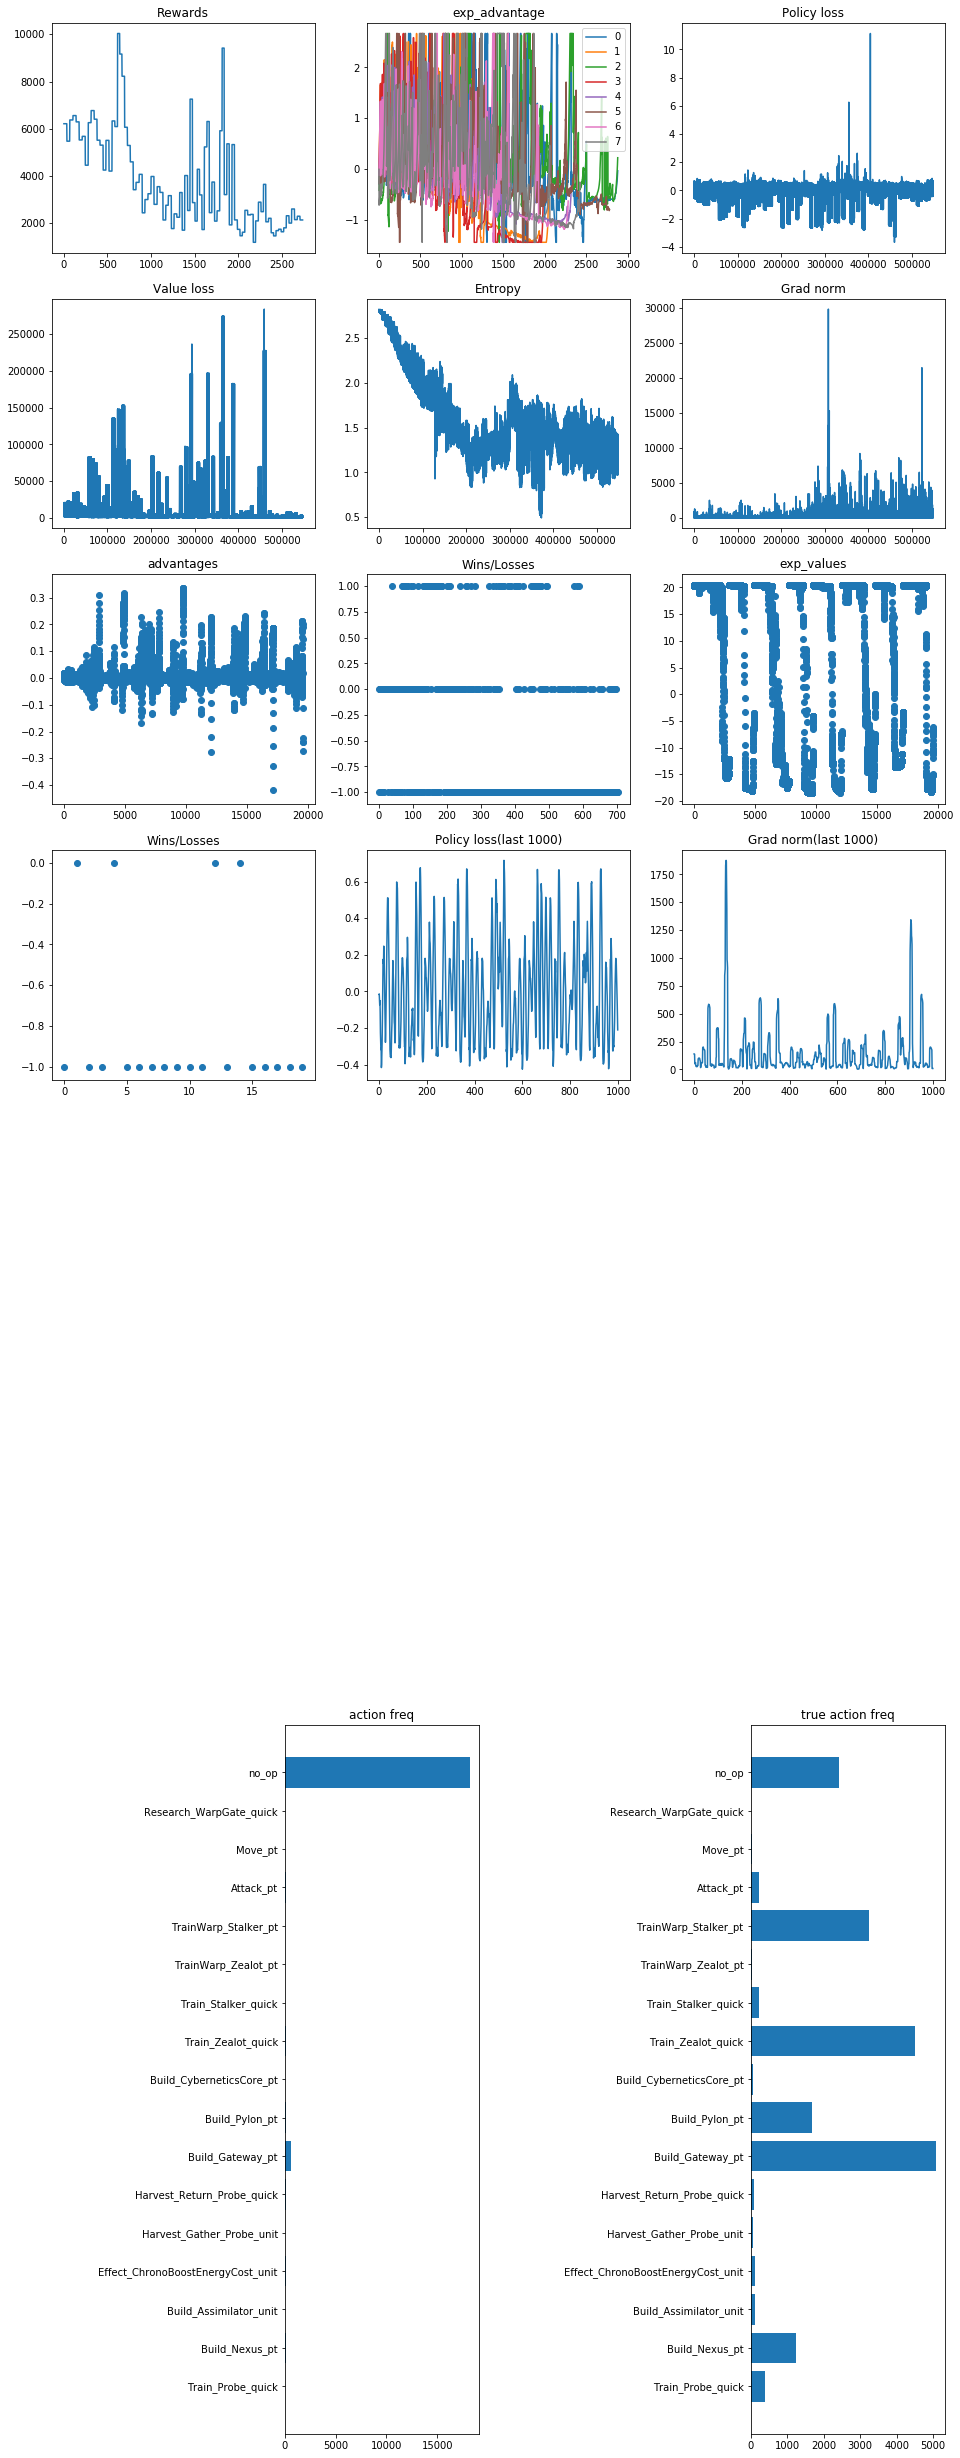

 55%|█████▍    | 547600/999999 [25:02:06<61:57:34,  2.03it/s]/home/scvotan/miniconda3/envs/rl/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
 55%|█████▍    | 547768/999999 [25:02:16<7:26:53, 16.87it/s] 

Difficulty.easy
running:  0


/home/scvotan/miniconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:271: DeprecationWarning: using non-Enums in containment checks will raise TypeError in Python 3.8
 55%|█████▍    | 547768/999999 [25:02:35<7:26:53, 16.87it/s]/home/scvotan/miniconda3/envs/rl/lib/python3.7/site-packages/ipykernel_launcher.py:305: DeprecationWarning: using non-Enums in containment checks will raise TypeError in Python 3.8


{4308860930: {4326424577, 4324851713, 4327473153}}
Collected_vespene: 76
Took 85.062 seconds for 2881 steps: 33.869 fps
result:  0
running:  1
{4336386049: {4327473153, 4326424577, 4327211009}}
Collected_vespene: 768
Took 59.379 seconds for 2069 steps: 34.844 fps
result:  -1
running:  2
{4332453889: {4327473153, 4325900289, 4324589569}}
Collected_vespene: 1372
Took 50.770 seconds for 1867 steps: 36.774 fps
result:  -1
running:  3
{4336910337: {4339269633, 4342939650, 4340580353}}
Collected_vespene: 772
Took 64.667 seconds for 2311 steps: 35.737 fps
result:  -1
running:  4
{4355522567: {4324851713, 4326948865, 4325900289}}
Collected_vespene: 796
Took 77.039 seconds for 2498 steps: 32.425 fps
result:  -1
running:  5


In [ ]:
rewards = 0
num = 0
rewards_list = []
# iterations = []

policy_loss = []
value_loss = []
entropies = []
grad_norms = []
sigmas = []
kls = []

lr = lr_init
for i in trange(1, n_steps):
    trajectory = sampler.get_next()
    ppo.step(trajectory)
#     sup_trajectory = sup_sampler.get_next()
#     supl.step(sup_trajectory)
    if i % 200 == 0:
#         raise Exception
        torch.save(policy.state_dict(), 'ppo.h5')
        torch.save(optim.state_dict(), 'optim.h5')

#         torch.save(sup_policy.state_dict(), 'super.h5')
#         torch.save(sup_optim.state_dict(), 'sup_optim.h5')
        clear_output(True)
        rewards_list.append(np.mean([np.sum(t['exp_reward']) for t in sampler.trajectory]))
        policy_loss.extend(ppo.history['policy_loss'])
        value_loss.extend(ppo.history['value_loss'])
        entropies.extend(ppo.history['entropy'])
        grad_norms.extend(ppo.history['grad_norm'])
        sigmas.extend(ppo.history['sigma'])
#         kls.extend(ppo.history['kl'])
        
        ppo.history = defaultdict(lambda: [])
        policy.random_proba = max(policy.random_proba*0.99, 0.00)
        print(policy.random_proba)
        print(ppo.exp_coef, ppo.kl_coef)
        
        plt.figure(figsize=(16, 60))
        n = 12
        
        plt.subplot(12, 3, 1)
        plt.title("Rewards")
        plt.plot(rewards_list)
        
        plt.subplot(12, 3, 2)
        plt.title("exp_advantage")
#         advs = np.hstack([t['exp_advantage'] for t in sampler.trajectory])
        for i, t in enumerate(sampler.trajectory):
            plt.plot(t['exp_advantage'], label=str(i))
            plt.legend()
            
        
        
#         plt.subplot(5, 3, 2)
#         plt.title("Sigma")
#         plt.plot(smoothen(sigmas))
##         plt.ylim([-1500, 3000])
        
        plt.subplot(12, 3, 3)
        plt.title("Policy loss")
        plt.plot(smoothen(policy_loss))
        
        plt.subplot(12, 3, 4)
        plt.title("Value loss")
        plt.plot(smoothen(value_loss))
        
        plt.subplot(12, 3, 5)
        plt.title("Entropy")
        plt.plot(smoothen(entropies))
        
        plt.subplot(12, 3, 6)
        plt.title("Grad norm")
        plt.plot(smoothen(grad_norms))
        
        plt.subplot(12, 3, 7)
        plt.title("advantages")
        advs = np.hstack([t['advantage'] for t in sampler.trajectory])
        plt.scatter(range(len(advs)), advs)
        
        plt.subplot(12, 3, 8)
        plt.title("Wins/Losses")
        plt.scatter(range(len(runner.results)), runner.results)
        
        plt.subplot(12, 3, 9)
        plt.title("exp_values")
        vls = np.hstack([t['exp_values'] for t in sampler.trajectory])
        plt.scatter(range(len(vls)), vls)
        
        plt.subplot(12, 3, 10)
        plt.title("Wins/Losses")
        plt.scatter(range(len(runner.results[-20:])), runner.results[-20:])
        
#         plt.subplot(9, 3, 10)
#         plt.title("KL")
#         plt.plot(smoothen(kls))
        
        plt.subplot(12, 3, 11)
        plt.title("Policy loss(last 1000)")
        plt.plot(smoothen(policy_loss)[-1000:])
        
        plt.subplot(12, 3, 12)
        plt.title("Grad norm(last 1000)")
        plt.plot(smoothen(grad_norms)[-1000:])
        
#         plt.subplot(9, 3, 13)
#         plt.title("KL(last 1000)")
#         plt.plot(smoothen(kls)[-1000:])
        
        plt.subplot(4, 4, 10)
        plt.title("action freq")
        plt.barh(PROTOSS_ACTIONS, sampler.action_stats['action_freq'])
#         plt.xticks(rotation=90)
        
        plt.subplot(4, 4, 12)
        plt.title("true action freq")
        plt.barh(PROTOSS_ACTIONS, sampler.action_stats['true_action_freq'])
#         plt.xticks(rotation=90)
        
#         plt.subplot(4, 2, 7)
#         plt.title("Pt coords")
#         plt.imshow(sampler.action_stats['map'][:, :, 1:])
        
#         plt.subplot(4, 2, 8)
#         plt.title("ALL")
#         plt.imshow(sampler.action_stats['map'][:, :, :3])
        print(sampler.action_stats['units'])
        
#         plt.subplot(9, 1, 7)
#         plt.title("exp_values")
#         vls = np.hstack([t['exp_values'] for t in sampler.trajectory])
#         plt.scatter(range(len(vls)), vls)
        
#         plt.subplot(9, 1, 8)
#         plt.title("exp_values")
#         vls = np.hstack([t['exp_values'] for t in sampler.trajectory])
#         plt.scatter(range(len(vls)), vls)

        plt.show()
#         raise Exception

In [ ]:
#Сделай смесь гауссиан, где среднее будет в бинах, а std и все остальное настраивается, их много надо

In [ ]:
# print(i)

In [ ]:
plt.plot(sampler.trajectory[0]['exp_values'])

In [ ]:
plt.plot(sampler.trajectory[0]['exp_value_target'])

In [ ]:
plt.plot(sampler.trajectory[0]['exp_advantage'])

In [ ]:
plt.plot(sampler.trajectory[0]['exp_value_target'])

In [ ]:
# for param in policy.parameters():
#     print("param.data",torch.isfinite(param.data).all())
#     if param.grad is not None:
#         print("param.grad.data",torch.isfinite(param.grad.data).all())
# #     else:
# #         print(param)
#     print()

In [ ]:
# for i in range(len(sampler.trajectory)):
#     print(np.isnan(sampler.trajectory[i]['log_probs']).any())
#     print(sampler.trajectory[i]['log_probs'].min(), sampler.trajectory[i]['log_probs'].max())

In [ ]:
# print(param)

In [ ]:
# np.exp(-100)

In [ ]:
# a